# Importing Necessary Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from statistics import mean

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

import os
import base64
import io
import matplotlib.pyplot as plt

import joblib

from flask import Flask, render_template, request

# Data Acquisition

Sales Report database is gathered from Kaggle

In [2]:
"""https://www.kaggle.com/datasets/shivashi11/food-demand-prediction"""

'https://www.kaggle.com/datasets/shivashi11/food-demand-prediction'

In [3]:
saleDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\sales_info.csv")
saleDf.head()

id  Week  Center Id  Dish Id  Checkout Price  Base Price   
0  1379560     1         55     1885          136.83      152.29  \
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   Emailer For Promotion  Homepage Featured  Num Orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0                  0         189  
3                      0                  0          54  
4                      0                  0          40

In [4]:
dishDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")
dishDf.head()

Dish Id   Category Cuisine  Recipe Id
0     1885  Beverages    Thai       2614
1     1993  Beverages    Thai       4690
2     2539  Beverages    Thai      12872
3     1248  Beverages  Indian      12904
4     2631  Beverages  Indian       2620

In [5]:
centerDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\fulfilment_center_info.csv")
centerDf.head()

Center Id  City Code  Region Code Center Type  Op Area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6

Dish Ingredient database is downloaded from RecipeDB website

In [6]:
"""https://cosylab.iiitd.edu.in/recipedb/"""

'https://cosylab.iiitd.edu.in/recipedb/'

Web Scrapping code to get Dish ingredient

In [7]:
r = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")

In [8]:
def convert_to_float(frac_str):
    num = " "
    denom = 1
    whole = 0
    if re.findall("[a-zA-Z]", frac_str) or None or "":
        return 0
    else:
        try:
            return float(frac_str)
        except ValueError:
            try: 
                num, denom = frac_str.split('/')
            except ValueError:
                num = frac_str
            try:
                leading, num = num.split(' ')
                whole = float(leading)
            except ValueError:
                whole = 0
            num = num if re.findall("[0-9]",num) else 0 
            frac = float(num) / float(denom)
            return whole - frac if whole < 0 else whole + frac


Scarping Code

In [9]:
recipeId = list(r["Recipe Id"])
d_ings = []
d_names = []
data = []
dumData = []
print("Dishes we are using in this model")
for num, i in enumerate(recipeId):
    url = "https://cosylab.iiitd.edu.in/recipedb/search_recipeInfo/{0}".format(i)
    
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')

    rows = soup.find('table', {'id':'myTable'}).find('tbody').find_all('tr')
    dish_name = soup.find('div', {'class':'col s12 m12'}).find('h3').text

    print(num + 1, dish_name, i)
    
    d = {}
    d["Dish Name"] = dish_name
    d["Recipe Id"] = i
    dumData.append(d)
    
    for row in rows:
        dict = {}
    
        dict["Recipe Id"] = i
        dict["Ingredient Name"] =  row.find_all('td')[0].text
        dict["Dish Name"] =  dish_name
        quantity = row.find_all('td')[1].text
        dict["Quantity"] = convert_to_float(quantity)
        unit = row.find_all('td')[2].text
        if unit == "":
            dict["Unit"] =  unit
        elif unit[len(unit)-1] == "s":
            dict["Unit"] =  unit[:len(unit) - 1]
        else:
            dict["Unit"] =  unit
        
        data.append(dict)


    
all_recipe = pd.DataFrame(data)
recipeData = pd.DataFrame(dumData)
all_recipe.to_csv(r"..\DataSet\Dish dataset\rawData.csv", index = False)

Dishes we are using in this model


1 Dukkah 2614
2 Spicy Beef Bulgogi 4690
3 Speculaas Cookies or Spicy Sinterklass Cakes 12872
4 Kletskopjes 12904
5 Egyptian Wheat Porridge (Belila) 2620
6 Buchi 3878
7 Tequeños 94044
8 Hungarian Sponge Cake (Piskota Torta) 105325
9 German Pancakes I 13117
10 Anna's German Dumplings 13116
11 Dutch Boterkoek 12907
12 Maja Blanca (Coconut Pudding) 3883
13 Basic Truffles 5162
14 Boscobel Beach Ginger Cake 8164
15 Roesti 10122
16 Pan de Sal - Filipino Bread Rolls 3925
17 Coconut Curried Tofu with Green Beans and Coconut Rice 4008
18 Smoky Gouda Cheese Dip 12895
19 English Monkey (Breakfast Snack) 104811
20 Besan Ladoo 5127
21 Speculaas 12897
22 Portuguese Burnt Sugar Candy 10145
23 Espiros 10147
24 Chocolate-Orange Rice Pudding 3862
25 Sambusa Pastry 47498
26 Chinky's Puto Bread 3910
27 Agni Beverage 68358
28 Mom's Kimchi Egg 4705
29 Heirloom Brown Sugar Cookies 100036
30 Portuguese Sweet Bread II 10149
31 Zucchini Tomato Pie 5163
32 Champurrado (Mexican Chocolate Beverage) 87347
33 Fortify

In [10]:
all_recipe = pd.read_csv(r"..\DataSet\Dish dataset\rawData.csv")
all_recipe.head()

Recipe Id Ingredient Name Dish Name  Quantity        Unit
0       2614        hazelnut    Dukkah  0.666667         cup
1       2614     sesame seed    Dukkah  0.500000         cup
2       2614  coriander seed    Dukkah  2.000000  tablespoon
3       2614      cumin seed    Dukkah  2.000000  tablespoon
4       2614    black pepper    Dukkah  2.000000  tablespoon

Cooking Measurement is taken from these website

In [11]:
"""https://www.aqua-calc.com/calculate/food-volume-to-weight"""

'https://www.aqua-calc.com/calculate/food-volume-to-weight'

In [12]:
"""https://www.thecalculatorsite.com/cooking/cooking-calculator.php"""

'https://www.thecalculatorsite.com/cooking/cooking-calculator.php'

In [13]:
vMeasure = pd.read_csv(r"..\Database\vMeasurement.csv")
vMeasure.head()

Ingredient Name  Quantity        Unit  Equivalent Quantity C_unit
0    active yeast         1    teaspoon              0.00475     Kg
1     adzuki bean         1         cup              0.20817     Kg
2          almond         1         cup              0.09837     Kg
3          almond         1  tablespoon              0.00590     Kg
4  almond extract         1    teaspoon              0.00500      L

# Preprocessing

preprocessing of Recipe Dataset

In [14]:
r = pd.read_csv(r"..\DataSet\Dish Sales dataset\meal_info.csv")
all_recipe = pd.read_csv(r"..\DataSet\Dish dataset\rawData.csv")

In [15]:
dict = {
    'Recipe Id' : r["Recipe Id"],
    'Dish Id' : r["Dish Id"]
} 

In [16]:
dd = pd.DataFrame(dict)

In [17]:
recipeData = recipeData.merge(dd, left_on='Recipe Id', right_on='Recipe Id', how ="left")
recipeData = recipeData.drop(['Recipe Id'], axis = 1)
recipeData.to_csv(r"..\Database\DishName.csv", index = False)

In [18]:
dum = dd.merge(all_recipe, left_on='Recipe Id', right_on='Recipe Id', how= "left")
dum = dum.sort_values(by = ['Ingredient Name', 'Unit'])
dum.to_csv(r"..\DataSet\Dish dataset\allRecipe.csv", index = False)

In [19]:
ar = pd.read_csv(r"..\DataSet\Dish dataset\allRecipe.csv")
ar = ar.sort_values(by = ['Ingredient Name', 'Unit'])
ar

Recipe Id  Dish Id Ingredient Name   
0         3925     2490    active yeast  \
1        10149     2569    active yeast   
2        47497     2104     adzuki bean   
3        12872     2539          almond   
4        12904     1248          almond   
..         ...      ...             ...   
338       4690     1993     white sugar   
339       3878     1311     white sugar   
340      13117     1803     white sugar   
341      12868     2956     white sugar   
342       5163     1230        zucchini   

                                        Dish Name  Quantity        Unit  
0               Pan de Sal - Filipino Bread Rolls       2.5    teaspoon  
1                       Portuguese Sweet Bread II       2.5    teaspoon  
2                           Somalian Adzuki Beans       0.5         cup  
3    Speculaas Cookies or Spicy Sinterklass Cakes       0.5         cup  
4                                     Kletskopjes       0.5         cup  
..                                            ...       ...         ...  
338                            Spicy Beef Bulgogi       2.5  tablespoon  
339                                         Buchi       2.0  tablespoon  
340                             German Pancakes I       2.0  tablespoon  
341                       Botercake (Butter Cake)       1.0  tablespoon  
342                           Zucchini Tomato Pie       2.0         cup  

[343 rows x 6 columns]

In [20]:
ar.isnull().sum()

Recipe Id           0
Dish Id             0
Ingredient Name     0
Dish Name           0
Quantity            0
Unit               20
dtype: int64

In [21]:
ar[ar["Unit"].isna()]

Recipe Id  Dish Id Ingredient Name   
127      94044     1062             egg  \
128     105325     1778             egg   
129      13117     1803             egg   
130      13116     1198             egg   
131       8164     2494             egg   
132       3925     2490             egg   
133     104811     1525             egg   
134      12897     1878             egg   
135      10147     2577             egg   
136       3910     2306             egg   
137       4705     2826             egg   
138     100036     2664             egg   
139      10149     2569             egg   
140       5163     1230             egg   
141       3882     1727             egg   
142      76669     1247             egg   
143      12867     1558             egg   
144      12894     1571             egg   
145      12868     2956             egg   
146      12871     1445             egg   

                                 Dish Name  Quantity Unit  
127                               Tequeños       2.0  NaN  
128  Hungarian Sponge Cake (Piskota Torta)       8.0  NaN  
129                      German Pancakes I       3.0  NaN  
130                Anna's German Dumplings       3.0  NaN  
131             Boscobel Beach Ginger Cake       4.0  NaN  
132      Pan de Sal - Filipino Bread Rolls       2.0  NaN  
133       English Monkey (Breakfast Snack)       1.0  NaN  
134                              Speculaas       1.0  NaN  
135                                Espiros      12.0  NaN  
136                    Chinky's Puto Bread       2.0  NaN  
137                       Mom's Kimchi Egg       2.0  NaN  
138           Heirloom Brown Sugar Cookies       3.0  NaN  
139              Portuguese Sweet Bread II       2.0  NaN  
140                    Zucchini Tomato Pie       3.0  NaN  
141              Philippine Butter Cookies       3.0  NaN  
142           Scroggins Biscuits (Cookies)       2.0  NaN  
143                      Holland Boterkoek       1.0  NaN  
144                   Dutch Letter Cookies       1.0  NaN  
145                Botercake (Butter Cake)       5.0  NaN  
146                 Dutch Almond Boterkoek       1.0  NaN

In [22]:
uniqueUnits= ar["Unit"].unique()
uniqueUnits

array(['teaspoon', 'cup', 'tablespoon', 'ounce', 'quart', nan, 'pound'],
      dtype=object)

In [23]:
for i in ar[ar["Ingredient Name"] == "egg"].index:
    ar.loc[i, 'Unit'] = ar.loc[i, 'Quantity']

In [24]:
ar[ar["Unit"].isna()]

Empty DataFrame
Columns: [Recipe Id, Dish Id, Ingredient Name, Dish Name, Quantity, Unit]
Index: []

In [25]:
ar.to_csv(r"..\Database\allRecipe.csv", index = False)

Creating Empty Inventory

In [26]:
inventory = ar.drop(['Recipe Id','Dish Id','Dish Name'], axis = 1)
inventory["Quantity"] = inventory["Quantity"].replace(list(inventory["Quantity"]), 0)
inventory = inventory.drop_duplicates()
inventory = inventory.sort_values(by = ['Ingredient Name', 'Unit'])
inventory.to_csv(r"..\Database\inventory.csv", index = False)

preprocessing of Historical sales dataset

In [27]:
le = LabelEncoder()
encData = {}
sales = saleDf.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")
sales = sales.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
col = ["Category", "Cuisine","Center Type"]
for column in col:
    enc = sales[column].unique()
    enc1 = list(set(le.fit_transform(sales[column])))
    for name, data in zip(enc,enc1):
        encData[name] = data

In [28]:
def preprocessModule1(df):
    
    df['Week'] = df['Week'].astype('int64')
    df['Center Id'] = df['Center Id'].astype('int64')
    df['Dish Id'] = df['Dish Id'].astype('int64')
    df['Checkout Price'] = df['Checkout Price'].astype('float64')
    df['Base Price'] = df['Base Price'].astype('float64')
    df['Emailer For Promotion'] = df['Emailer For Promotion'].astype('int64')
    df['Homepage Featured'] = df['Homepage Featured'].astype('int64')

    #Remove unnecessary fields
    if "id" in list(df.columns):
        df = df.drop(['id'], axis=1) 
        

    #Merging of dataframes
    df = df.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
    df = df.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")

    #Encoding the record
    for name, data in encData.items():
        df = df.replace(name,data)

        
    return df

In [29]:
def preprocessSTL(df):
    
    tempData = df
    
    sStl = data_stl.drop(['Num Orders'], axis = 1)
    
    tempData["Trend"] = np.nan
    tempData["Seasonal"] = np.nan
    tempData["Residual"] = np.nan
    
    tempData = pd.concat([sStl, tempData], axis = 0)
    
    tempData = performImputation(tempData)
    
    return tempData.tail(len(df))

In [30]:
def stlDecomposition(data, target_column, period):
    
    result = seasonal_decompose(data[target_column], model='additive', period = period)

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    data_stl = pd.concat([trend, seasonal, residual], axis=1)
    data_stl.columns = ["Trend", "Seasonal", "Residual"]
    data_stl = pd.concat([data, data_stl], axis=1)

    return data_stl

In [31]:
def performImputation(X):
    
    imputer = IterativeImputer(estimator= HistGradientBoostingRegressor(max_iter=100, max_depth=5, min_samples_leaf=5))
    X_filled = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_filled, columns = X.columns)

    return X_imputed

# Model Training

In [32]:
def fitModel(model, X_train, y_train):
    
    return model.fit(X_train, y_train)

In [33]:
def trainModel(X_train, Y_train):
    
    gb = fitModel(GradientBoostingRegressor(n_estimators=100,
                                            max_depth=5,
                                            min_samples_leaf=5,
                                            learning_rate=0.1),
                  X_train,
                  Y_train)
    hgb = fitModel(HistGradientBoostingRegressor(max_iter=100,
                                                 max_depth=5,
                                                 min_samples_leaf=5),
                   X_train,
                   Y_train)
    rf = fitModel(RandomForestRegressor(n_estimators=100,
                                        max_depth=5,
                                        min_samples_leaf=5),
                  X_train,
                  Y_train)
    
    return gb, hgb, rf

In [34]:
saleDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\sales_info.csv")

In [35]:
saleDf = preprocessModule1(saleDf)
saleDf.to_csv(r"..\Database\mainData.csv", index= False)
saleDf.head()

Week  Center Id  Dish Id  Checkout Price  Base Price   
0     1         55     1885          136.83      152.29  \
1     1         55     1993          136.83      135.83   
2     1         55     2539          134.86      135.86   
3     1         55     2139          339.50      437.53   
4     1         55     2631          243.50      242.50   

   Emailer For Promotion  Homepage Featured  Num Orders  Category  Cuisine   
0                      0                  0         177         0        0  \
1                      0                  0         270         0        0   
2                      0                  0         189         0        0   
3                      0                  0          54         0        1   
4                      0                  0          40         0        1   

   Recipe Id  City Code  Region Code  Center Type  Op Area  
0       2614        647           56            0      2.0  
1       4690        647           56            0      2.0  
2      12872        647           56            0      2.0  
3      68358        647           56            0      2.0  
4       2620        647           56            0      2.0

In [36]:
data = pd.read_csv("..\Database\mainData.csv")

In [37]:
data_stl = stlDecomposition(data, "Num Orders", period=7)
X = data_stl.drop("Num Orders", axis=1)
Y = data_stl["Num Orders"]
X_imputed = performImputation(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42, shuffle=False)
gb, hgb, rf = trainModel(X_train, Y_train)

In [38]:
def storePKL(gb, hgb, rf):
    pkl_dir = os.path.abspath('PKL')
    
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)

    gb_path = os.path.join(pkl_dir, 'gb.pkl')
    hgb_path = os.path.join(pkl_dir, 'hgb.pkl')
    rf_path = os.path.join(pkl_dir, 'rf.pkl')

    joblib.dump(gb, gb_path)
    joblib.dump(hgb, hgb_path)
    joblib.dump(rf, rf_path)

In [39]:
storePKL(gb, hgb, rf)

In [40]:
def getModel(model_name):
    
    pkl_dir = os.path.abspath('PKL')
    model_path = ""
    
    if model_name == "gradient_boosting":
        model_path = os.path.join(pkl_dir, 'gb.pkl')
    elif model_name == "random_forest":
        model_path = os.path.join(pkl_dir, 'rf.pkl')
    elif model_name == "hist_gradient_boosting":
        model_path = os.path.join(pkl_dir, 'hgb.pkl')
    else:
        print(f"Invalid model name: {model_name}")

    model = joblib.load(model_path)
    #model = joblib.load('hgb.pkl')

    return model

In [41]:
def runModel(model_name, X_test):

    model = getModel(model_name)
    Y_pred = model.predict(X_test)
    
    return model, Y_pred

In [42]:
import time
def timeTaken(model_name, X_test):
    start_time = time.time()
    
    model, Y_pred = runModel(model_name, X_test)
    
    r2 = r2_score(Y_test, Y_pred)
    print("R-squared score:", r2)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Time consumed by the ",model," Model is :" ,elapsed_time, "seconds")

In [43]:
timeTaken('gradient_boosting', X_test)

R-squared score: 0.9985937486524079
Time consumed by the  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5)  Model is : 0.19900774955749512 seconds


In [44]:
def modelSummary(model, X_test, Y_test):
    
    r2 = model.score(X_test, Y_test)
    
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    
    mse = mean_squared_error(Y_test, Y_pred)
    
    rmse = mse**0.5
    
    print("Model : ",model,"\nMAE : ", mae,"\nMSE :", mse,"\nRMSE :",rmse,"\nr2 score :",r2 , "\nAccuaracy :", r2*100,"%")

In [45]:
modelSummary(getModel("hist_gradient_boosting"), X_test, Y_test)

Model :  HistGradientBoostingRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  10.234096905151292 
MSE : 4226.528774474118 
RMSE : 65.01175874004731 
r2 score : 0.9684525863802402 
Accuaracy : 96.84525863802402 %


In [46]:
modelSummary(getModel("random_forest"), X_test, Y_test)

Model :  RandomForestRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  48.12510396541877 
MSE : 4701.991478748853 
RMSE : 68.5710688173143 
r2 score : 0.9649036649383436 
Accuaracy : 96.49036649383436 %


In [47]:
modelSummary(getModel("gradient_boosting"), X_test, Y_test)

Model :  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5) 
MAE :  8.422025608522812 
MSE : 188.40092111444596 
RMSE : 13.725921503288804 
r2 score : 0.9985937486524079 
Accuaracy : 99.8593748652408 %


In [48]:
center_id = saleDf['Center Id'].unique()
center_id = np.sort(center_id)
center_id = list(center_id)

In [49]:
dish_id = saleDf['Dish Id'].unique()
dish_id = np.sort(dish_id)
dish_id = list(dish_id)

In [50]:
dish_name = recipeData['Dish Name'].unique()
dish_name = np.sort(dish_name)
dish_name = list(dish_name)

In [51]:
def createGraphFolder(folder_names):
    current_dir = os.getcwd()
    graph_dir = os.path.join(current_dir, 'graph')
    
    if not os.path.exists(graph_dir):
        os.makedirs(graph_dir)
    
    for name in folder_names:
        folder_path = os.path.join(graph_dir, name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)


In [52]:
folder_names = ['HGB STL', 'GB STL', 'RF STL']

In [53]:
createGraphFolder(folder_names)

In [54]:
def saveGraph(dish_id, graph_path, img_string):
    img_data = base64.b64decode(img_string)
    
    with open(graph_path, 'wb') as f:
        f.write(img_data)
    
    img = plt.imread(graph_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [55]:
def generateAndSaveGraphs(folder_name, model, X_test, Y_test, dish_id):
    graph_dir = os.path.join('graph', folder_name)
    if not os.path.exists(graph_dir):
        os.makedirs(graph_dir)

    if 'Num Orders' in X_test.columns:
        X_test = X_test.drop(['Num Orders'], axis=1)

    if 'Y_pred' in X_test.columns:
        X_test = X_test.drop(['Y_pred'], axis=1)

    Y_pred = model.predict(X_test)

    df1 = X_test.copy()
    df1["Y_pred"] = Y_pred

    df2 = X_test.copy()
    df2["Num Orders"] = Y_test

    for i in dish_id:
        tempD1 = df1[df1["Dish Id"] == i]
        tempD2 = df2[df2["Dish Id"] == i]

        tempD1 = tempD1.groupby("Week").sum()
        tempD2 = tempD2.groupby("Week").sum()

        plt.figure(figsize=(10, 6))
        plt.plot(tempD2["Num Orders"].index, tempD2["Num Orders"], label='Actual Orders')
        plt.plot(tempD1["Y_pred"].index, tempD1["Y_pred"], label='Predicted Orders')

        plt.xlabel('weeks')
        plt.ylabel('Number of Orders for all Restaurants')
        plt.title(f'Actual vs Predicted Number of Orders sold per Week for Dish id: {i}')
        plt.legend()

        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='png')
        img_buffer.seek(0)
        img_string = base64.b64encode(img_buffer.getvalue()).decode()
        plt.close()

        graph_path = os.path.join(graph_dir, f'{i}.png')
        saveGraph(i, graph_path, img_string)


In [56]:
folderList = [("HGB STL", getModel("hist_gradient_boosting")),
              ("GB STL", getModel("gradient_boosting")),
              ("RF STL",getModel("random_forest"))]

Graph generated using the  HistGradientBoostingRegressor(max_depth=5, min_samples_leaf=5)


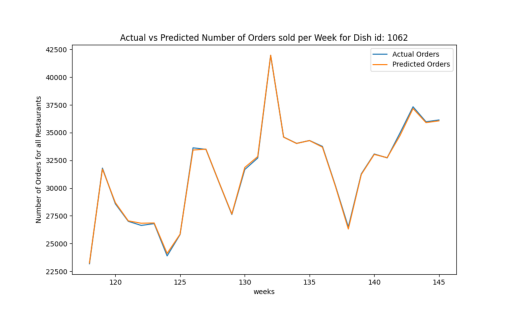

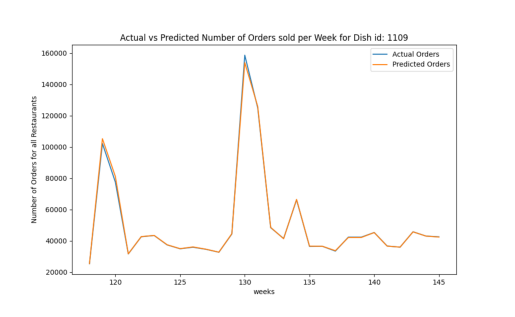

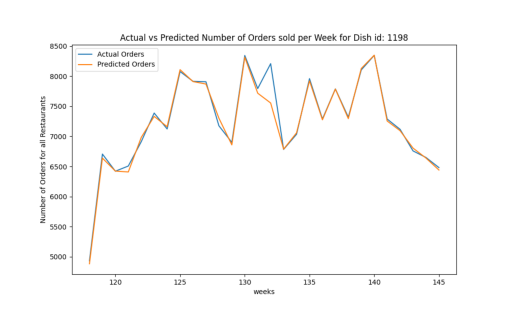

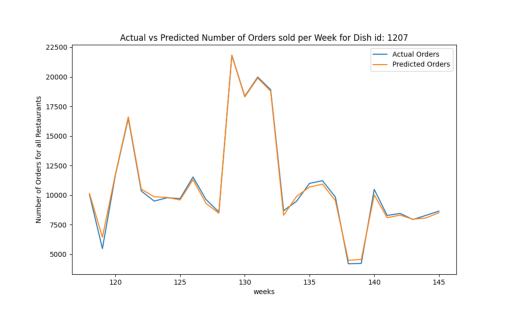

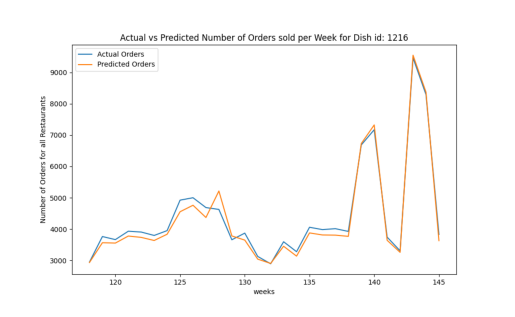

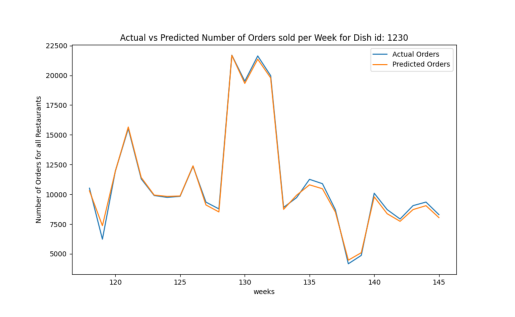

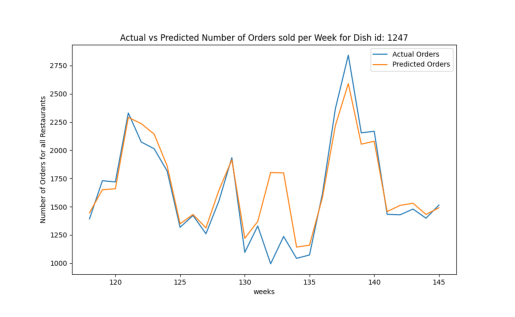

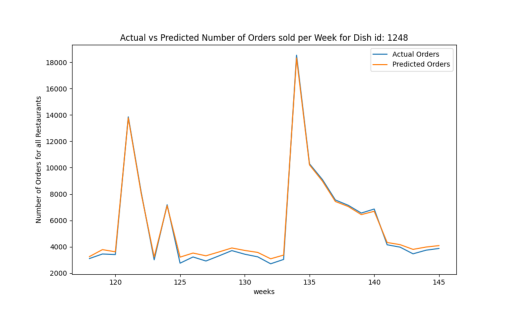

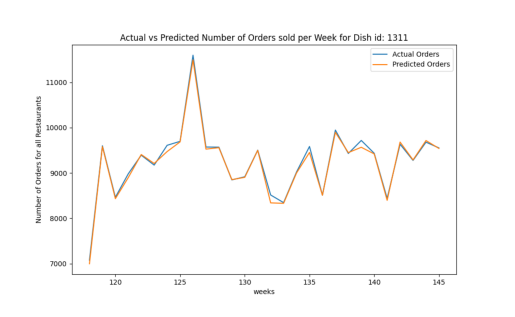

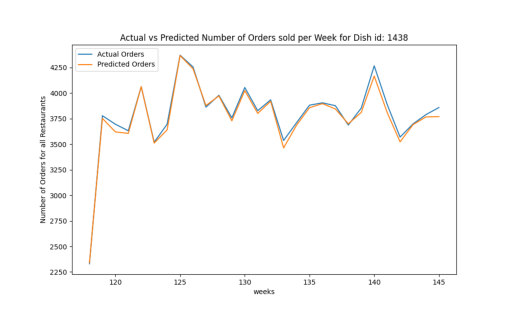

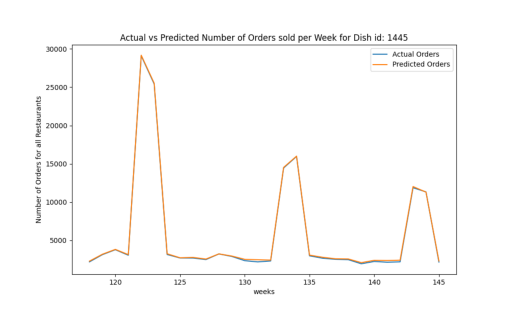

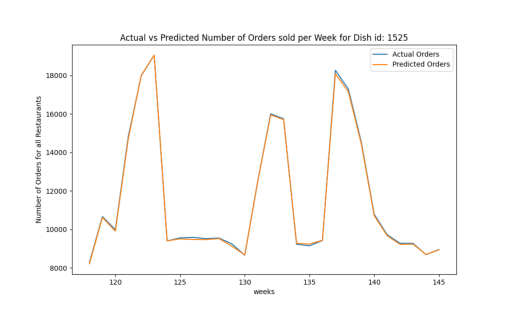

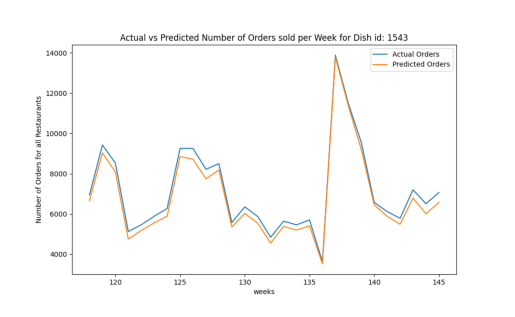

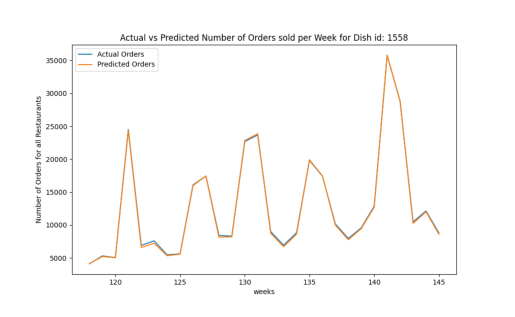

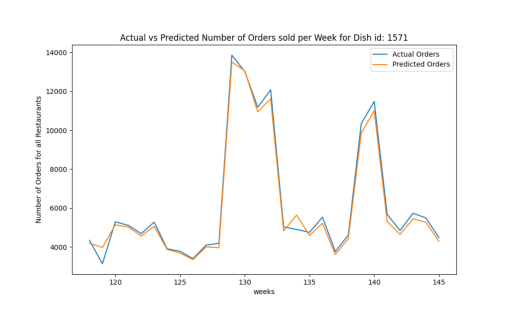

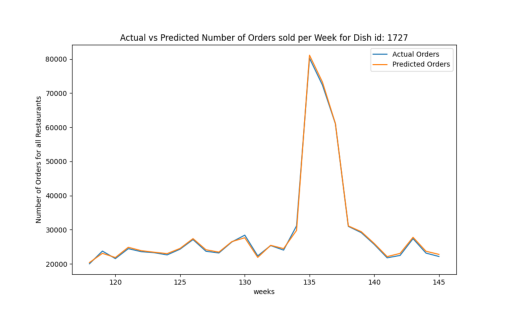

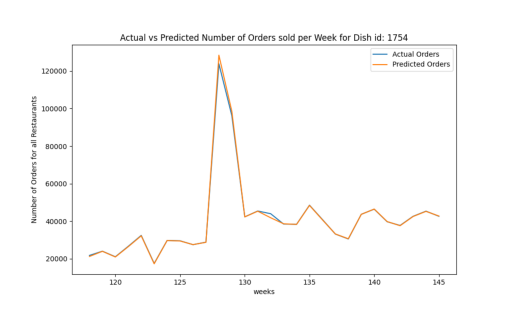

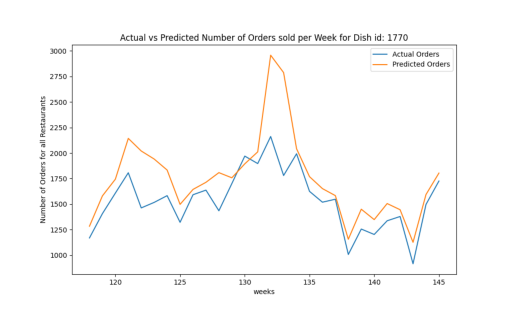

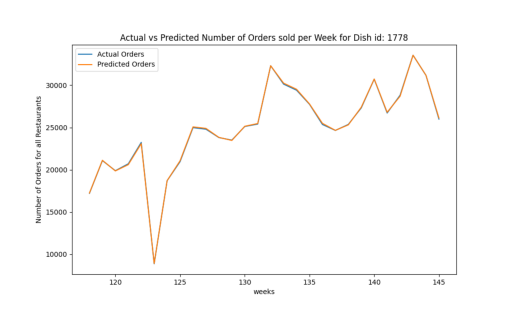

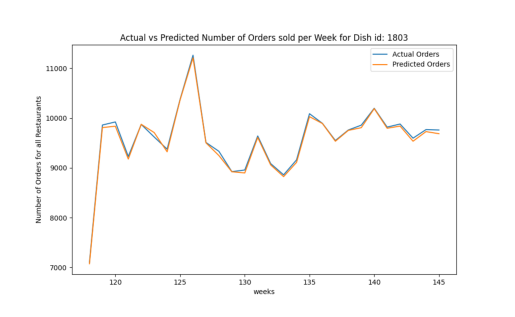

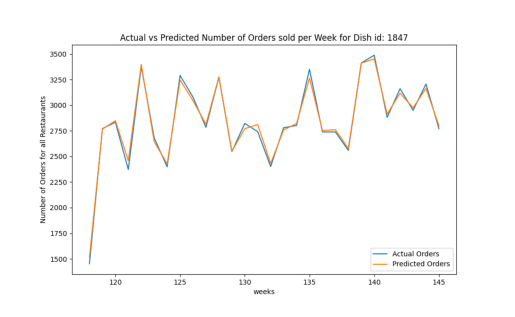

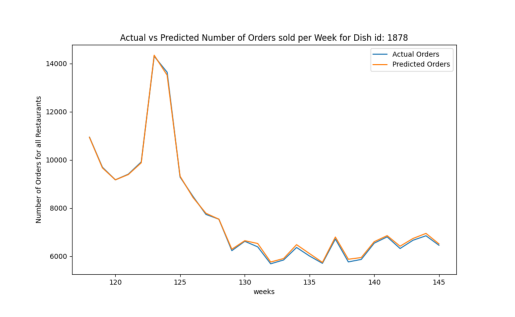

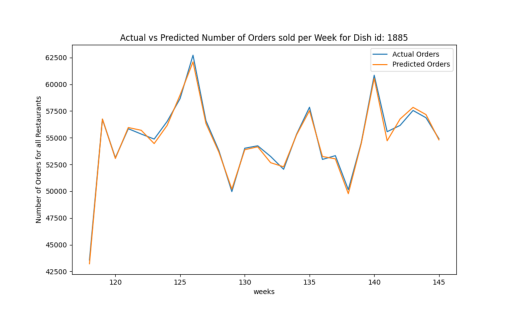

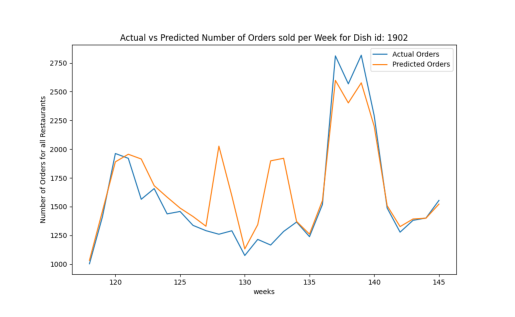

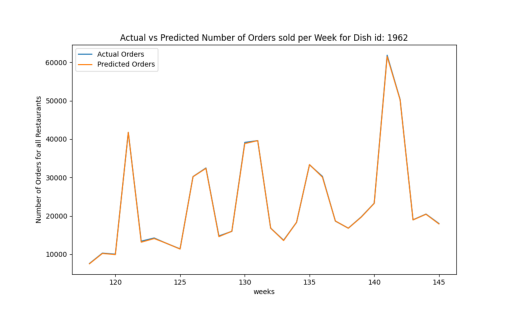

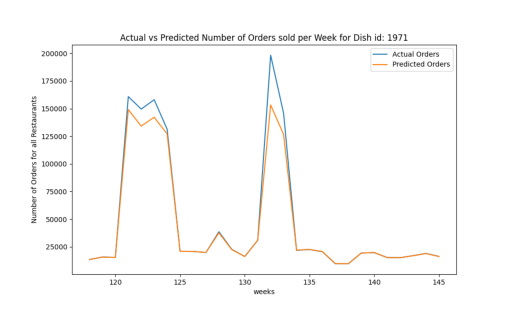

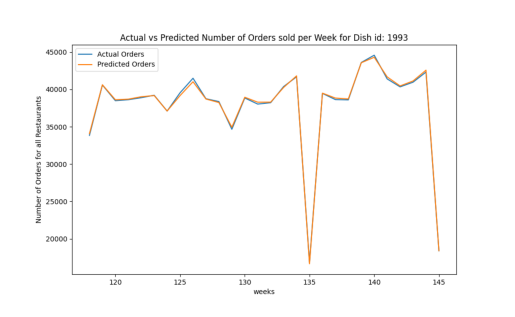

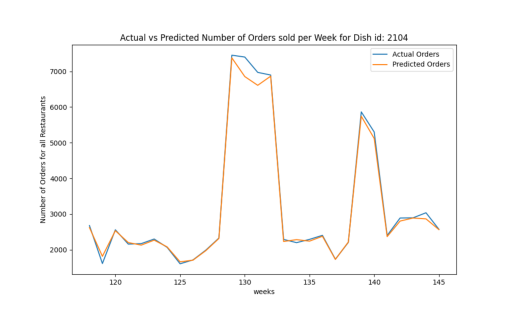

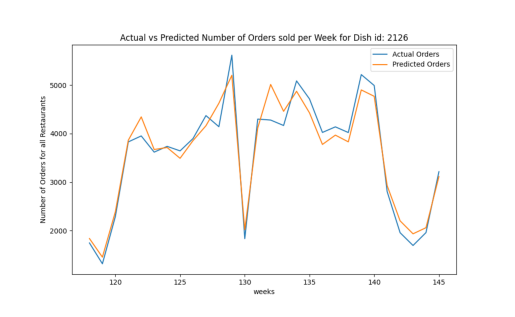

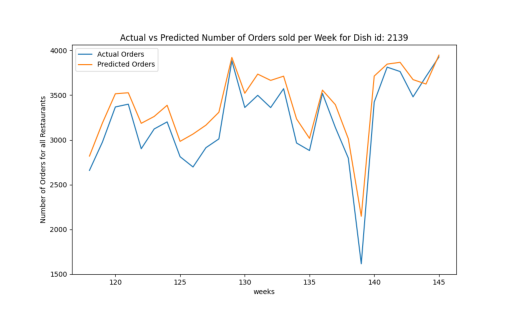

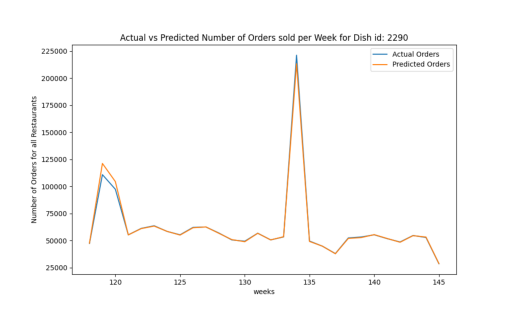

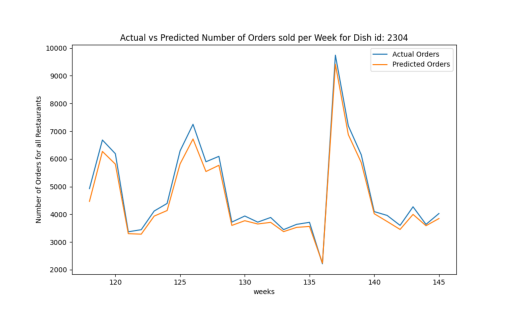

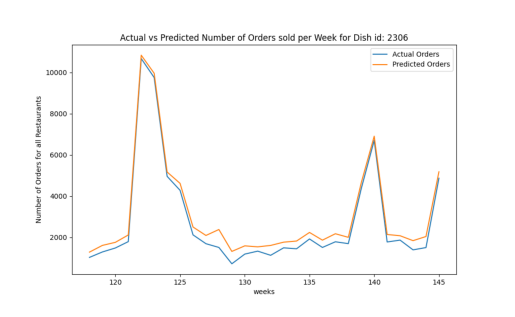

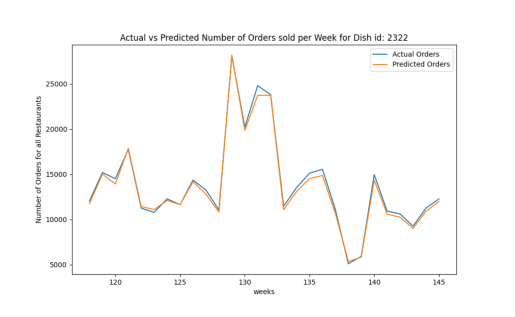

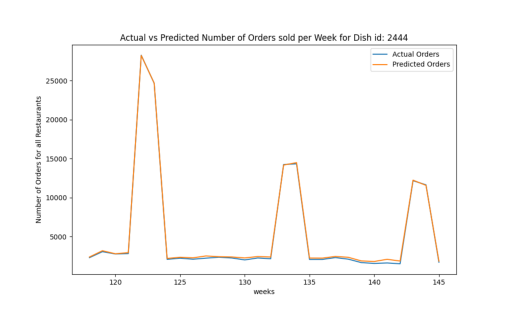

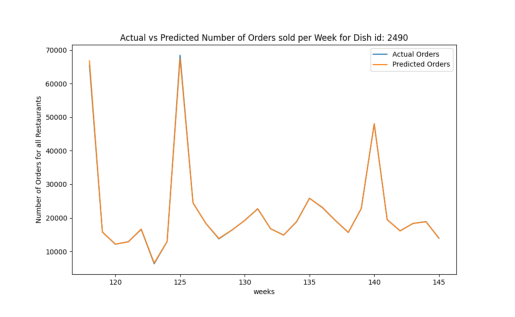

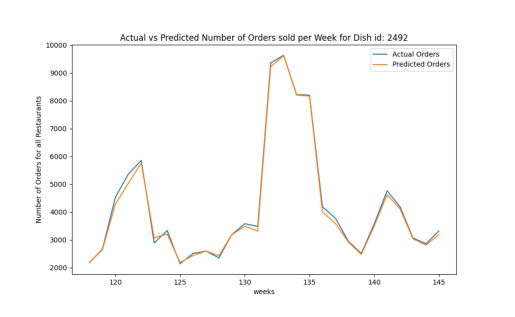

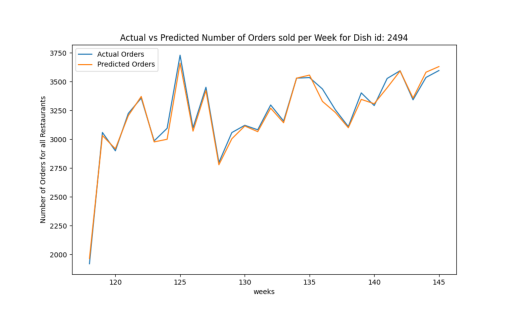

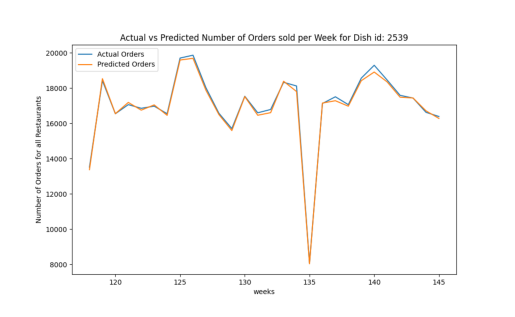

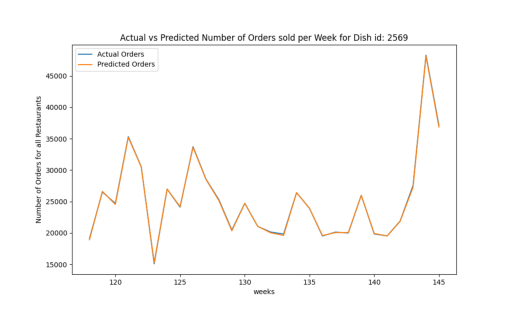

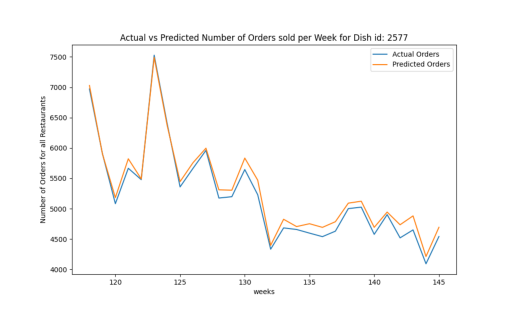

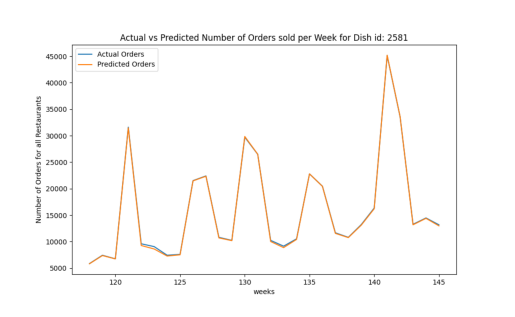

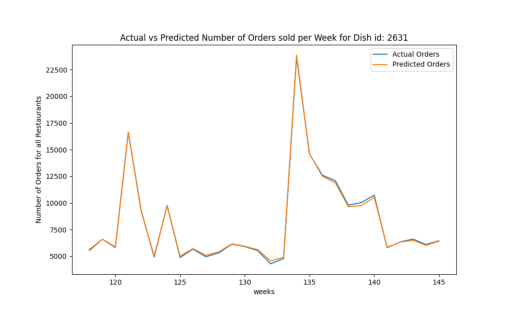

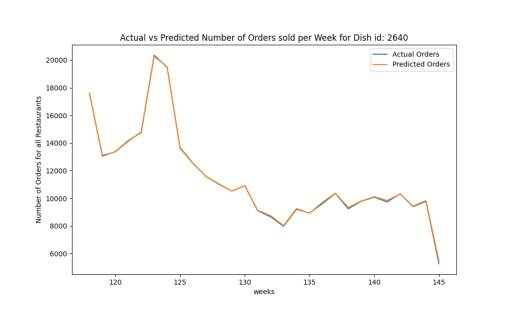

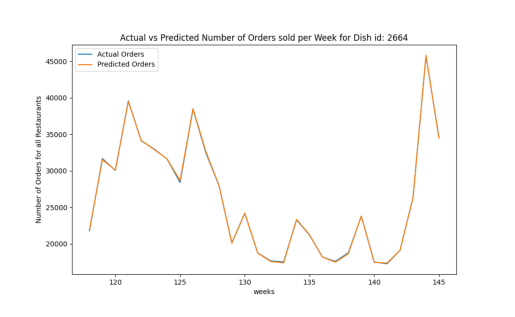

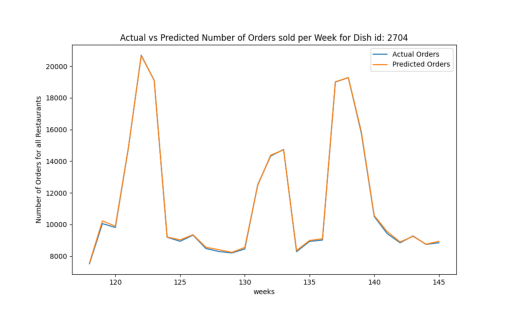

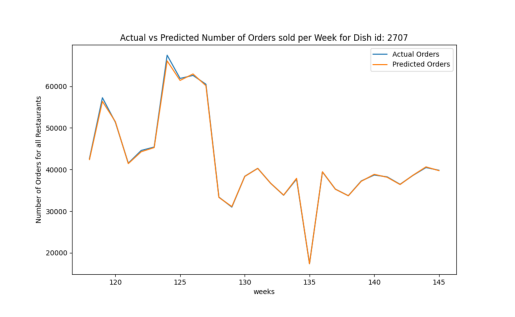

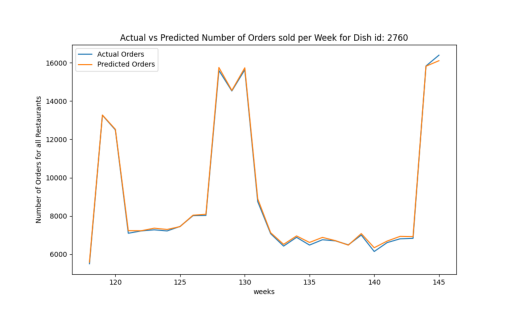

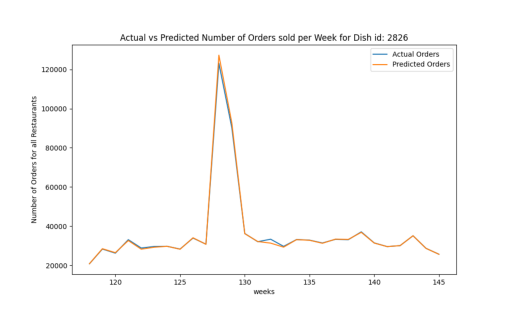

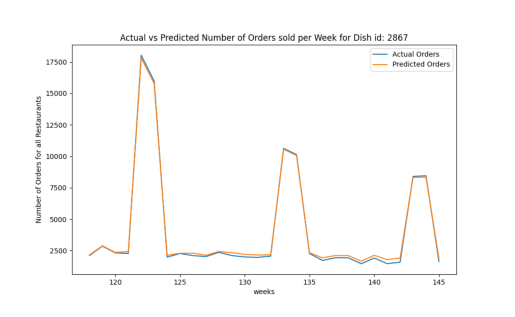

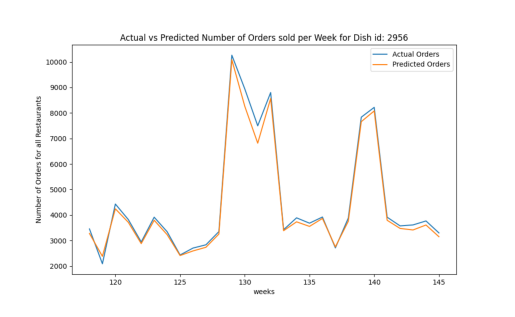


******************************************************

Graph generated using the  GradientBoostingRegressor(max_depth=5, min_samples_leaf=5)


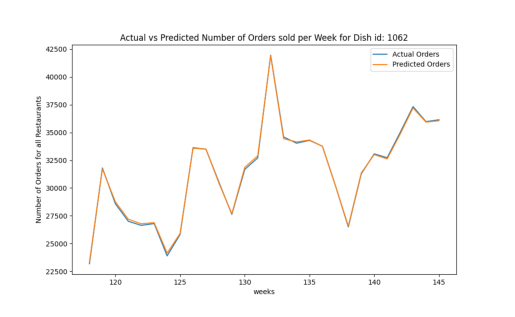

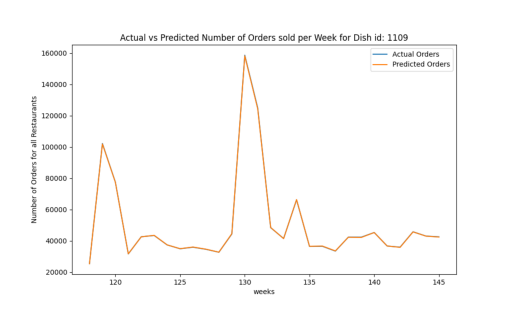

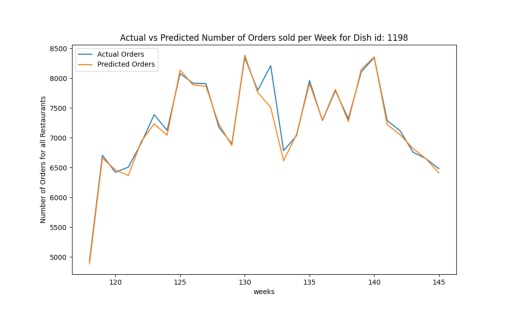

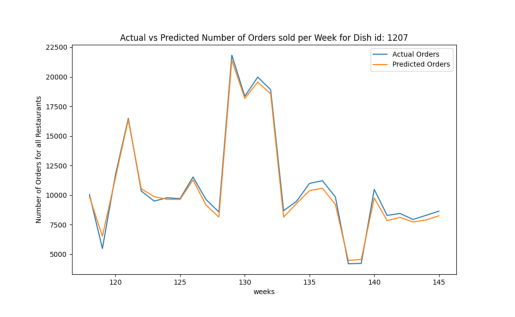

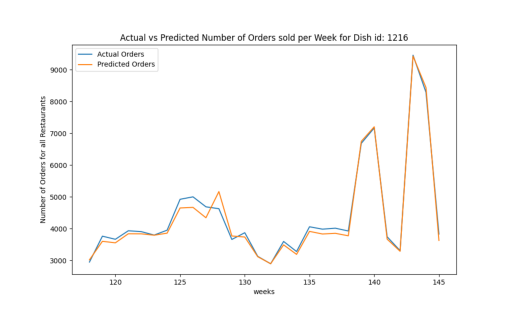

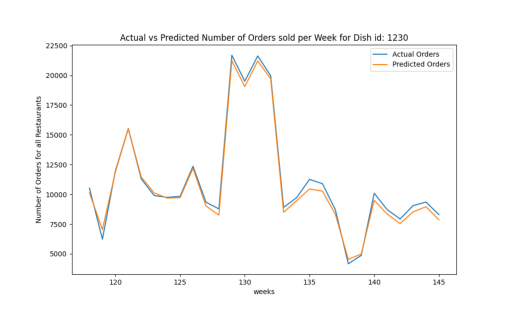

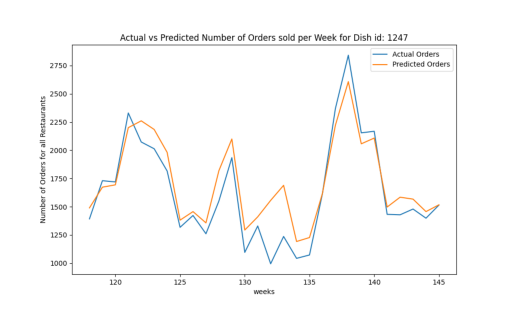

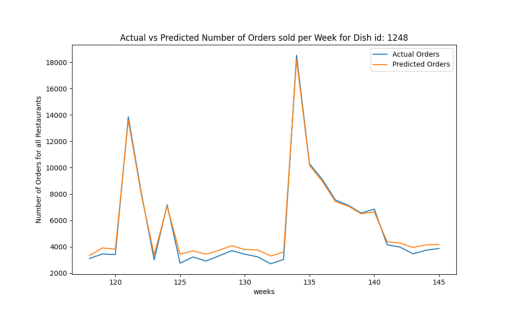

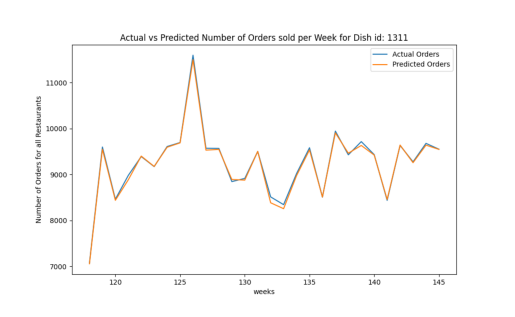

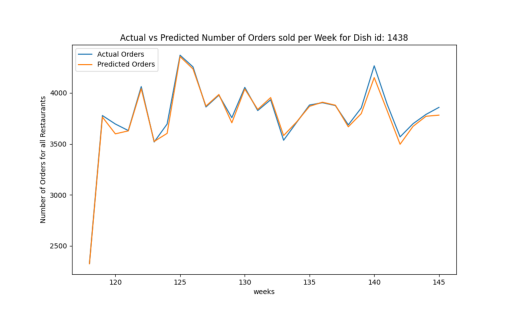

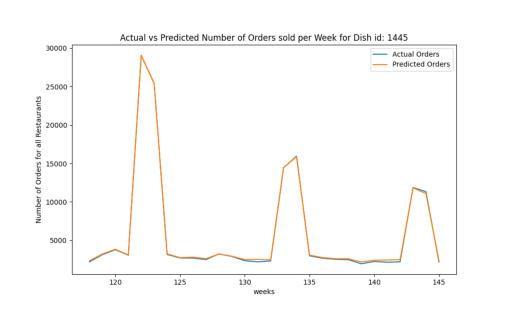

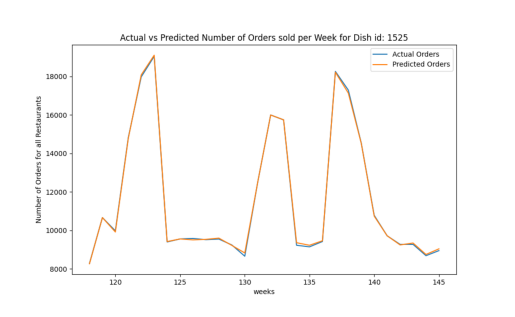

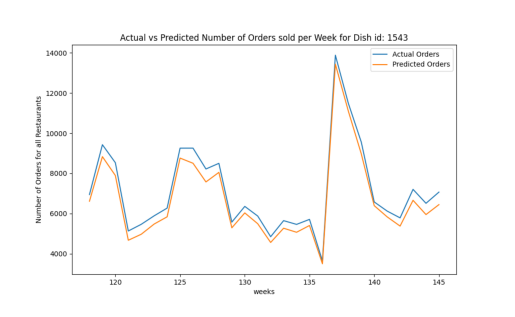

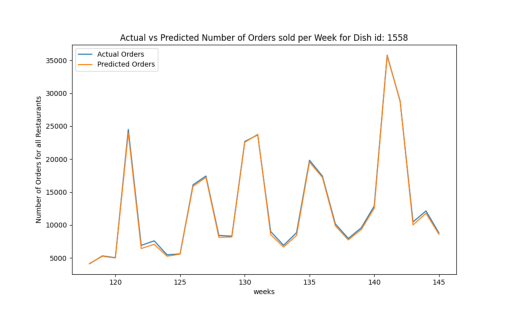

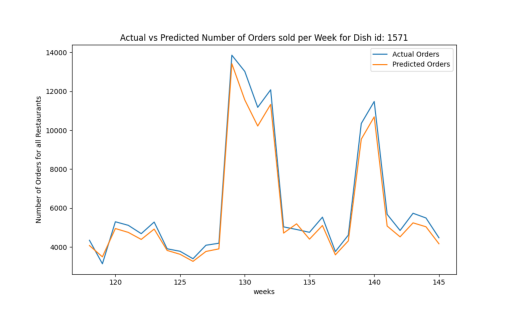

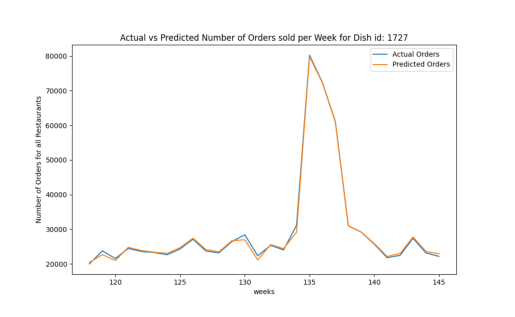

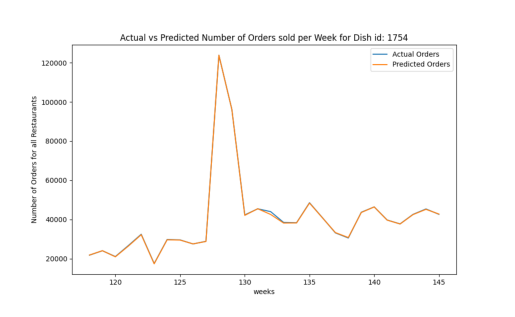

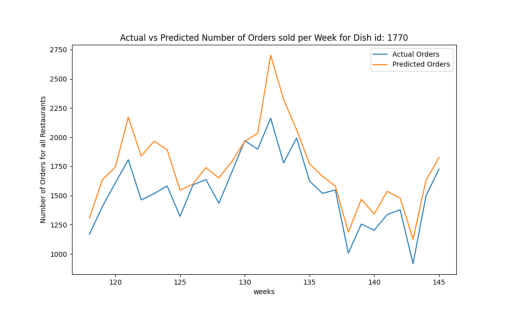

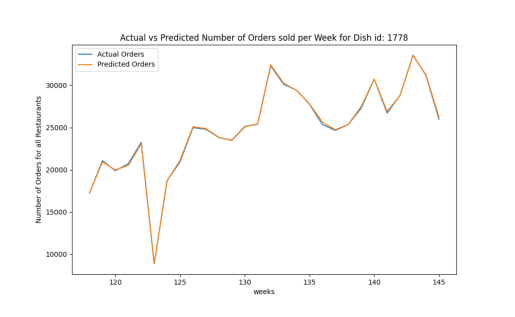

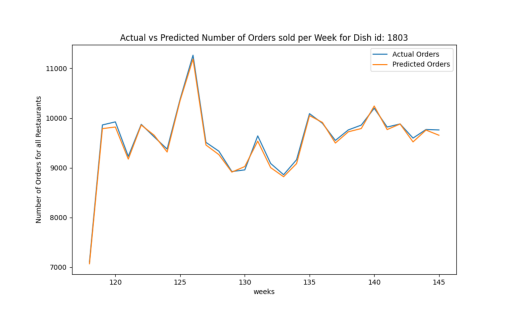

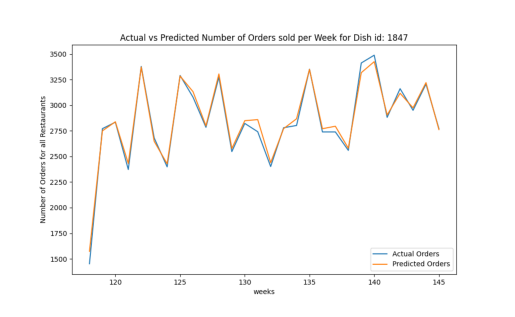

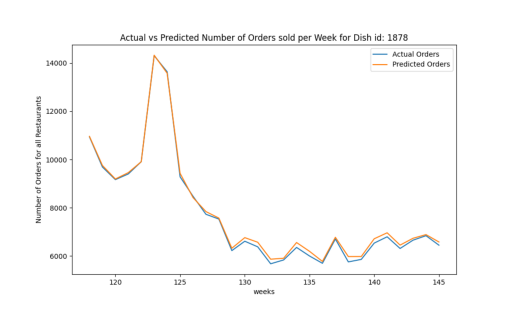

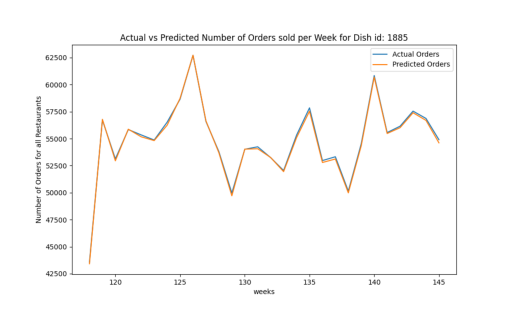

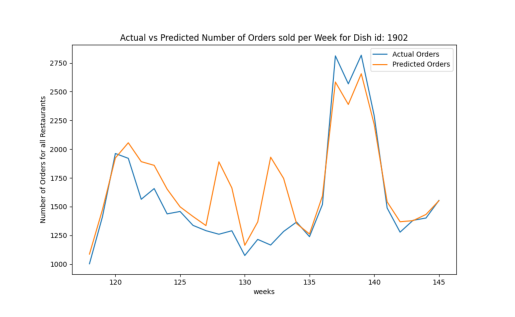

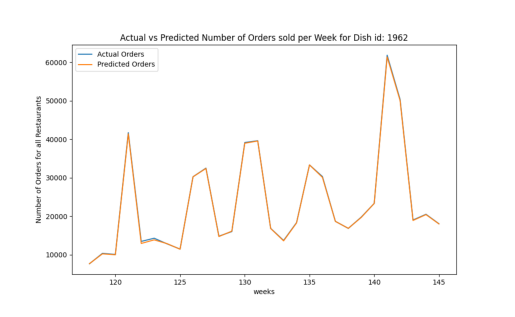

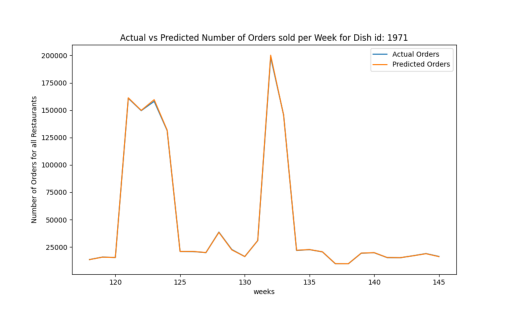

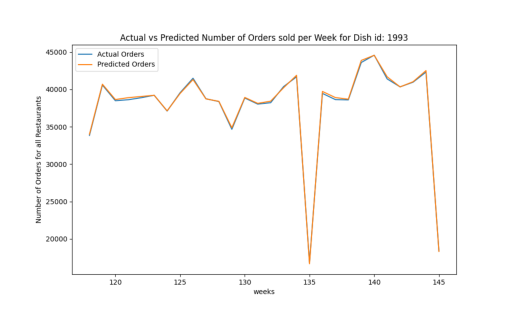

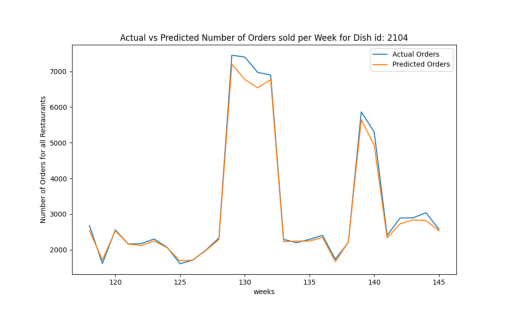

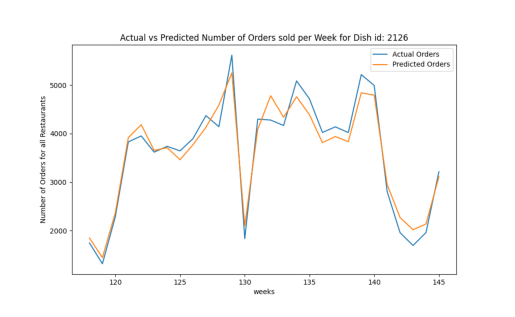

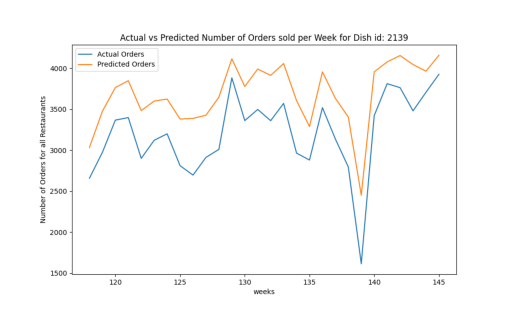

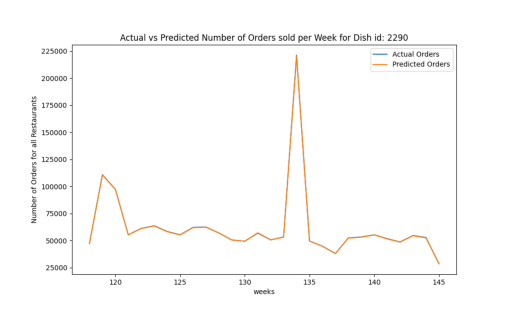

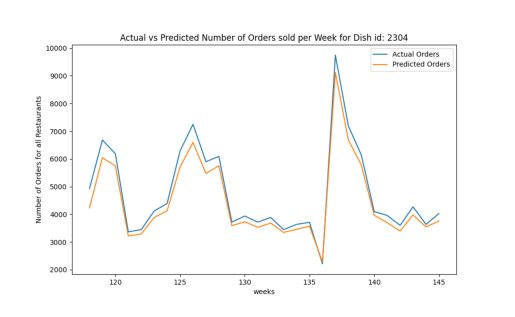

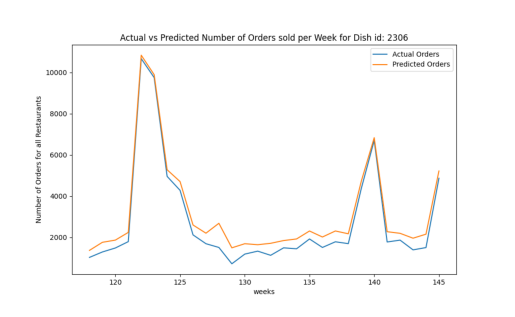

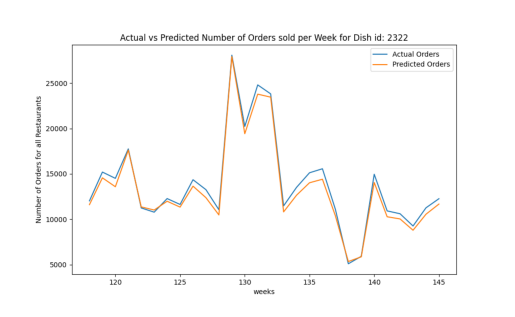

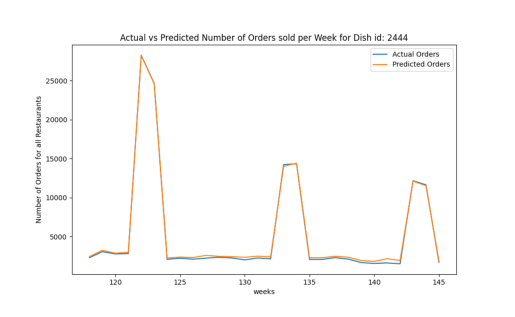

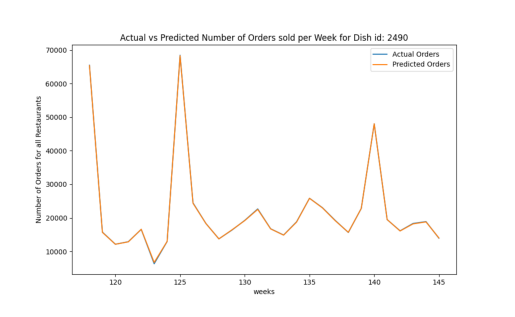

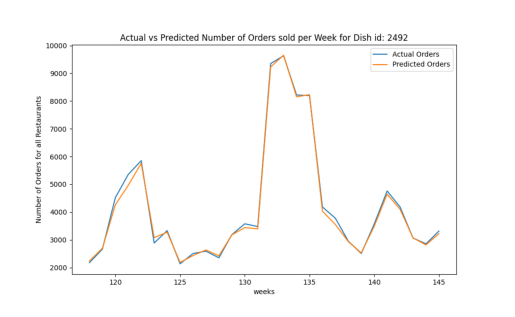

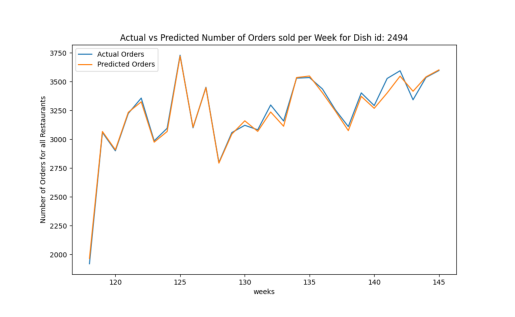

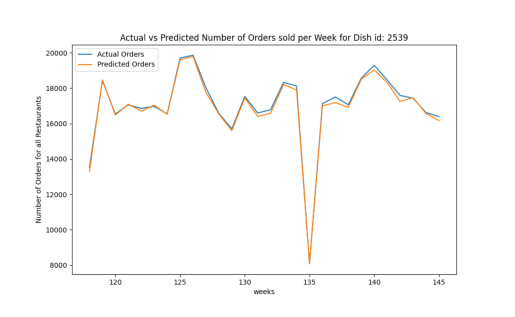

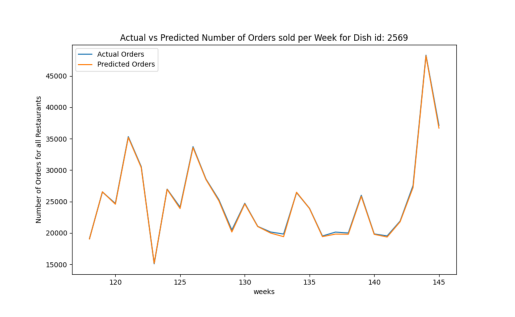

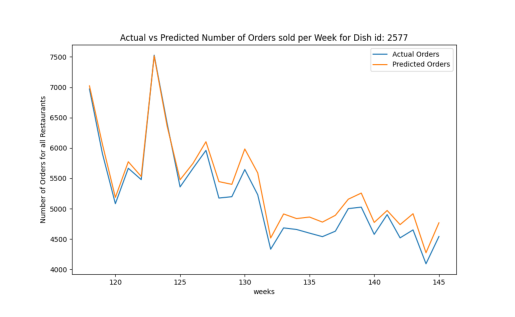

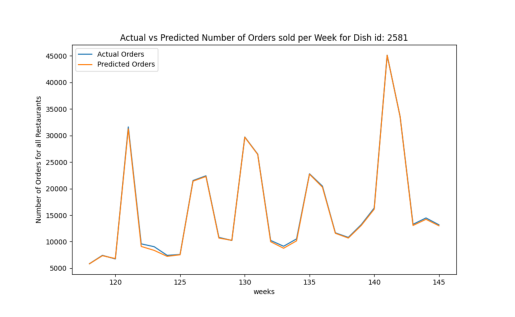

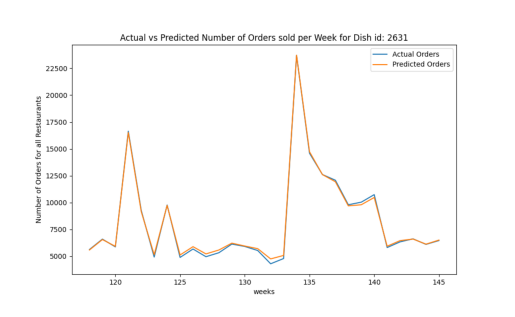

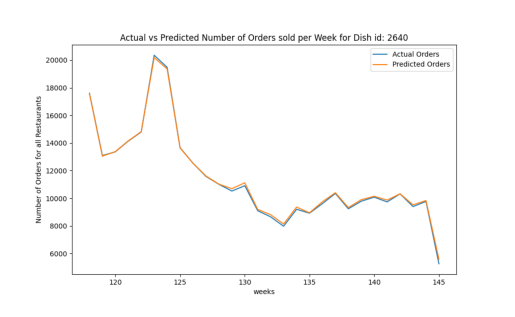

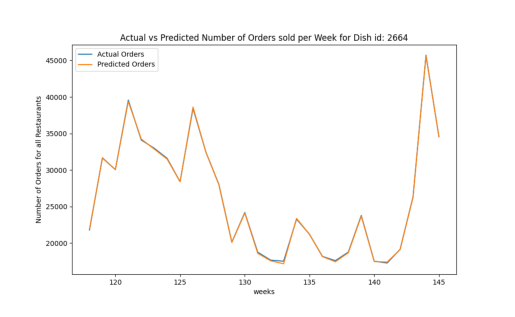

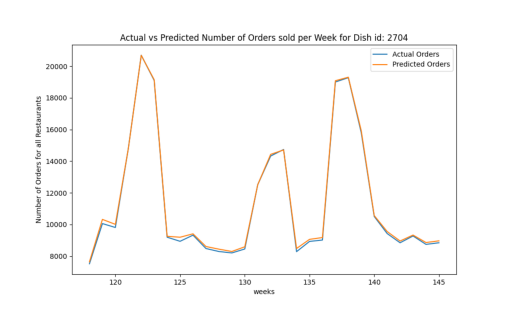

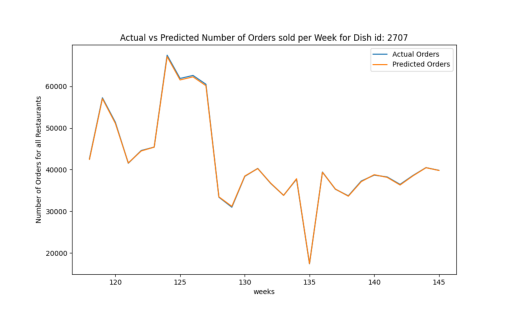

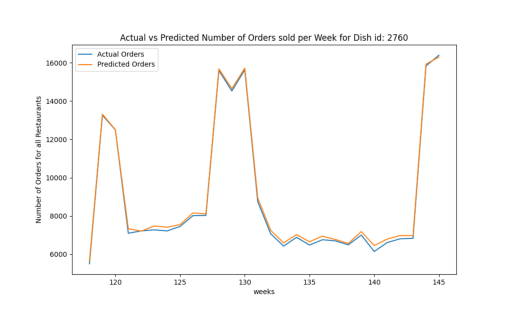

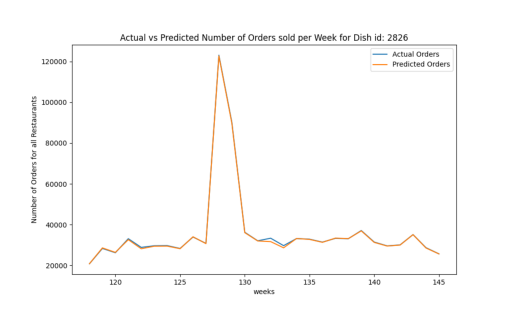

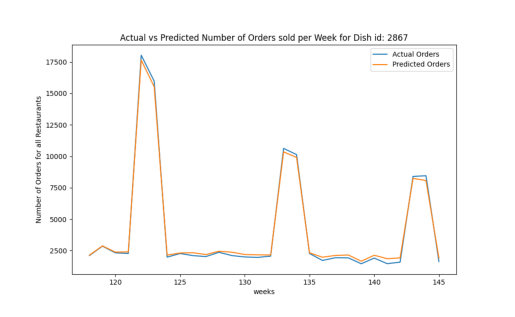

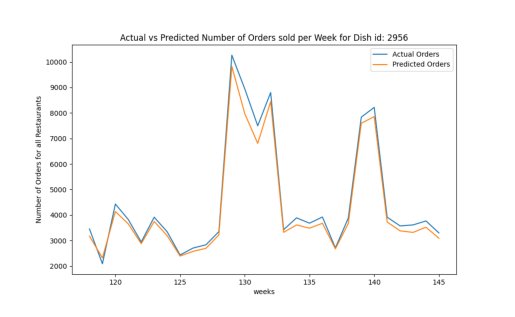


******************************************************

Graph generated using the  RandomForestRegressor(max_depth=5, min_samples_leaf=5)


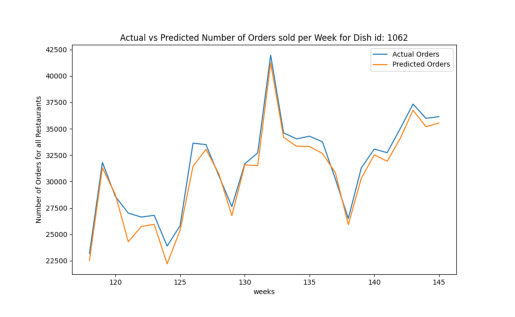

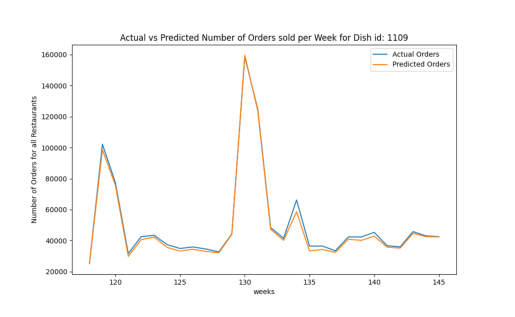

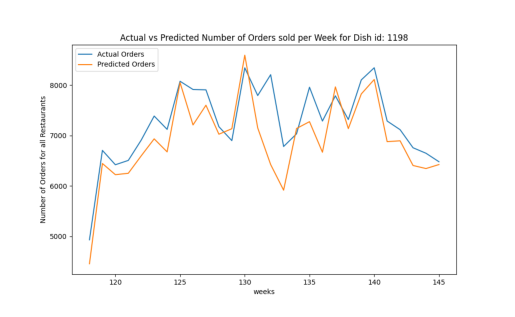

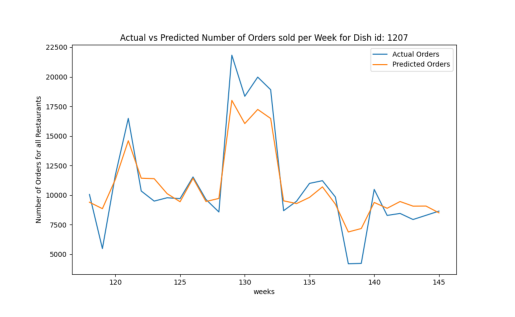

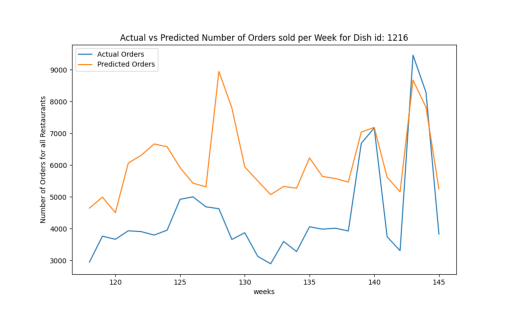

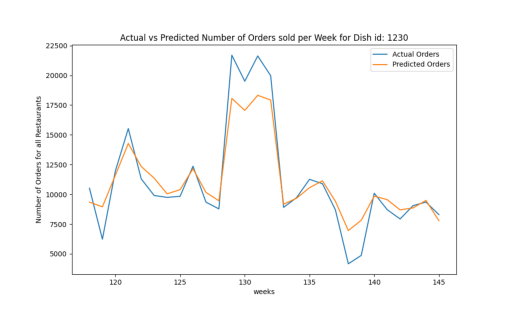

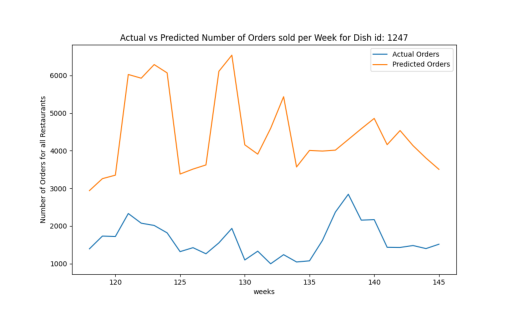

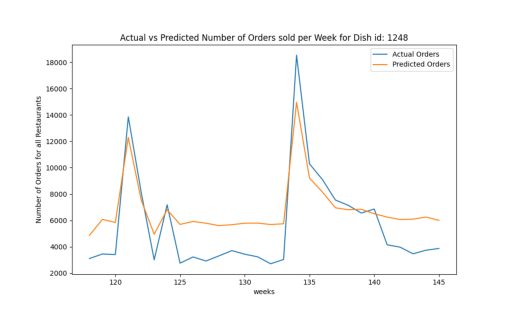

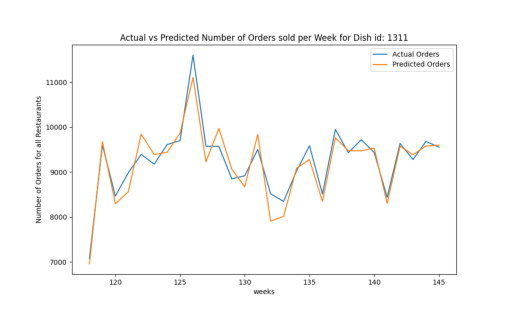

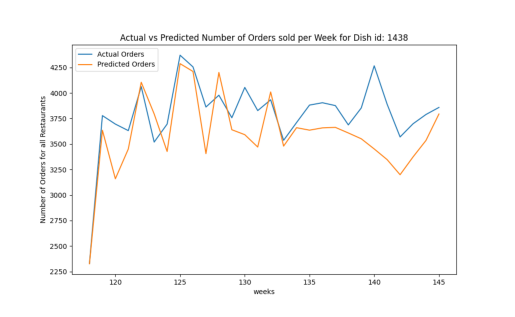

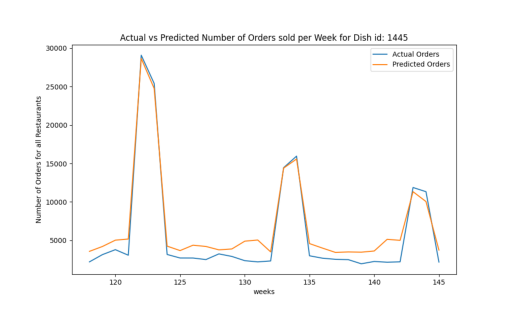

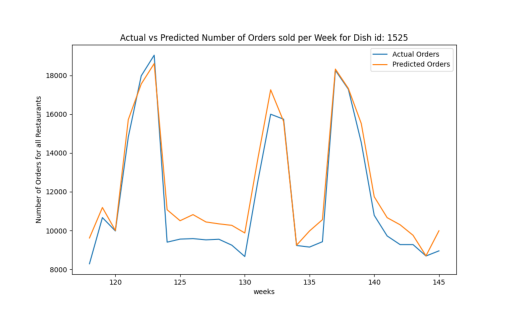

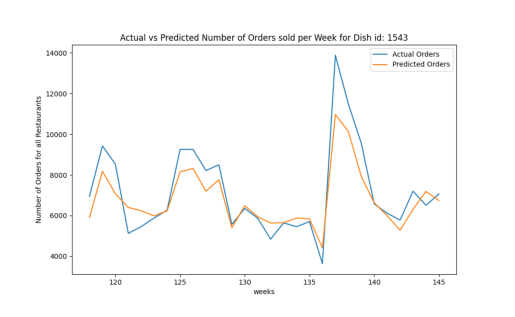

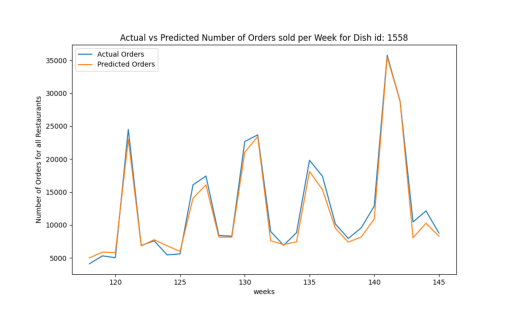

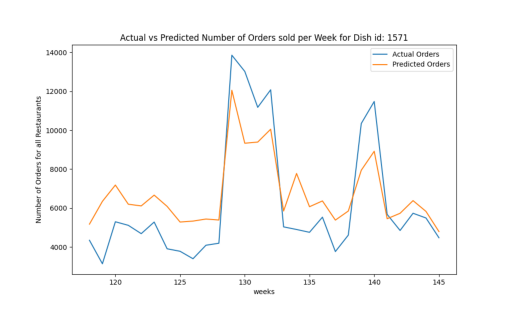

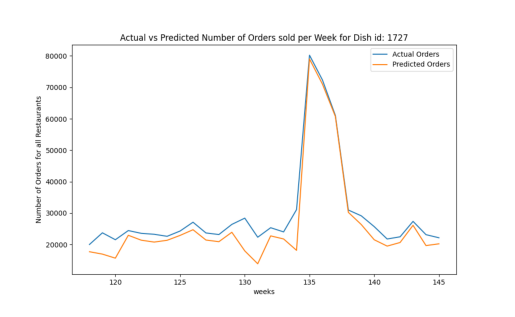

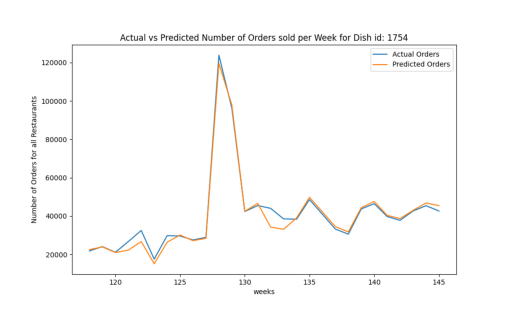

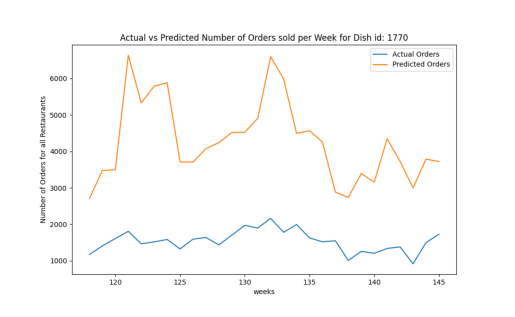

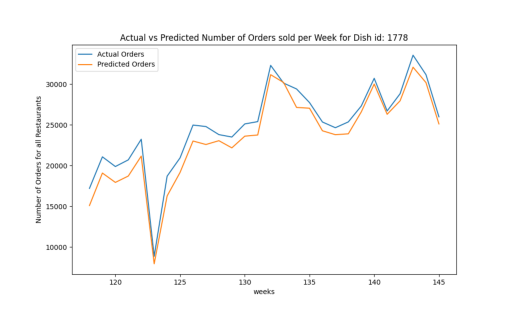

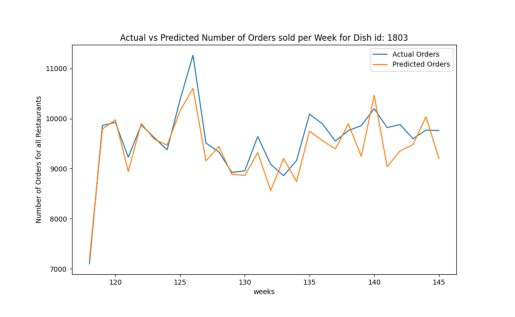

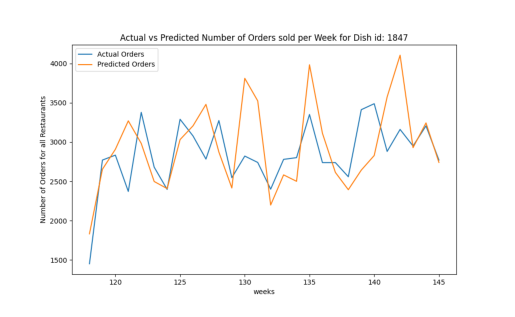

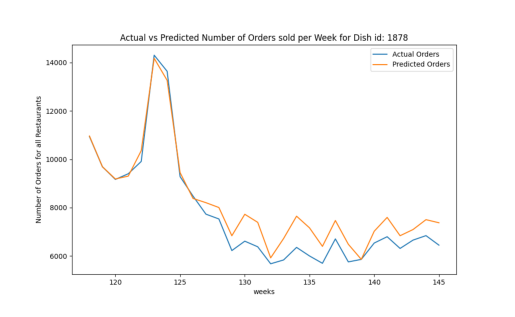

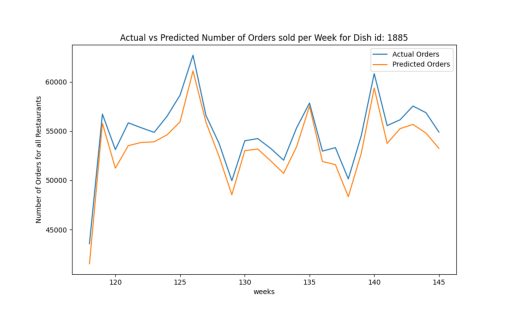

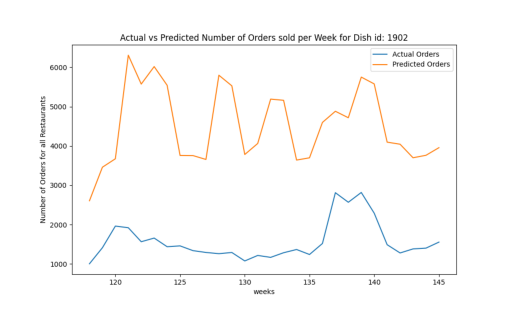

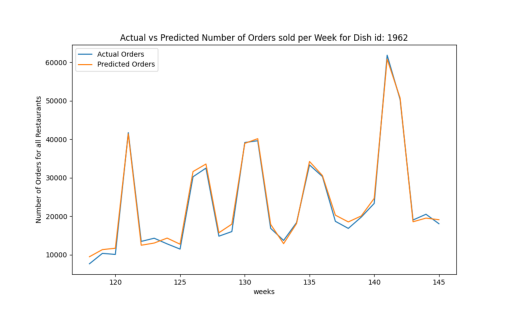

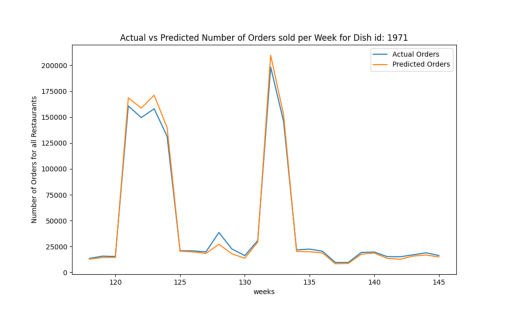

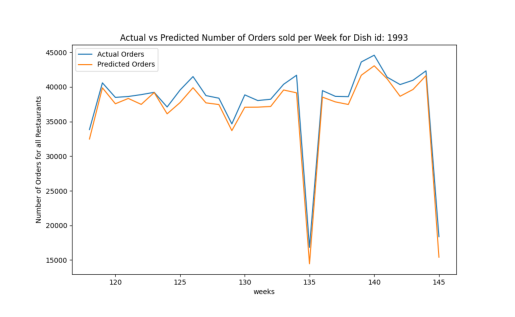

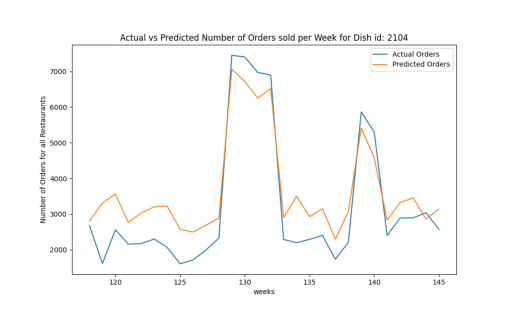

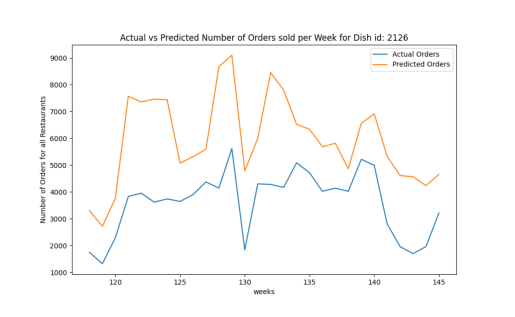

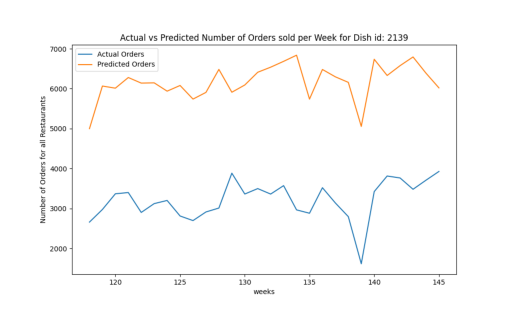

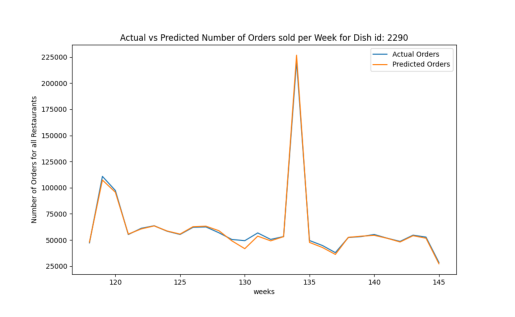

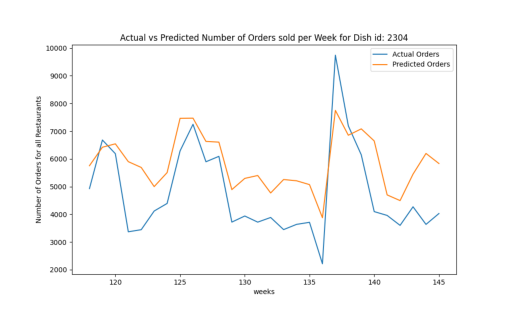

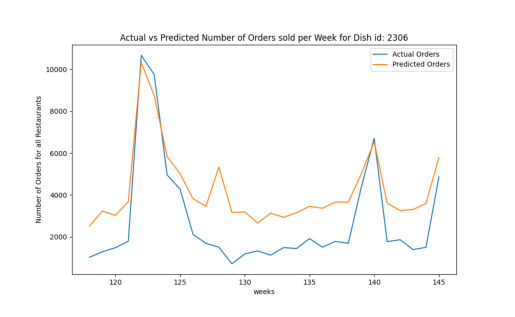

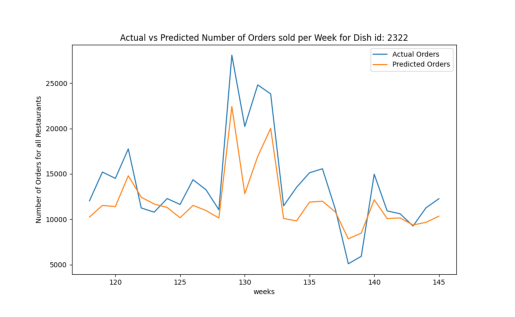

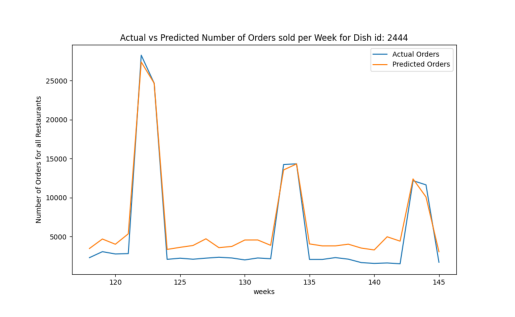

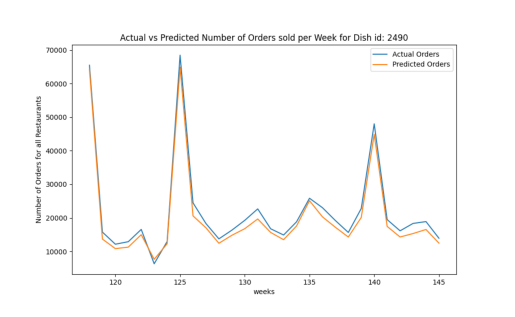

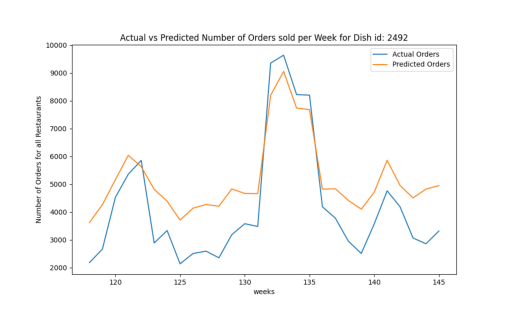

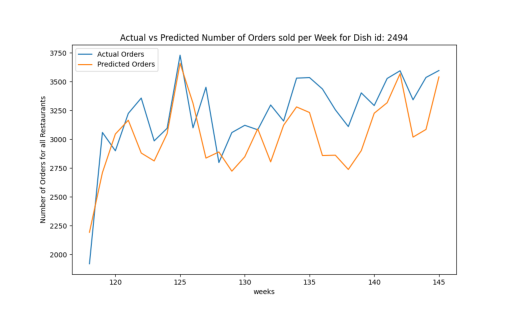

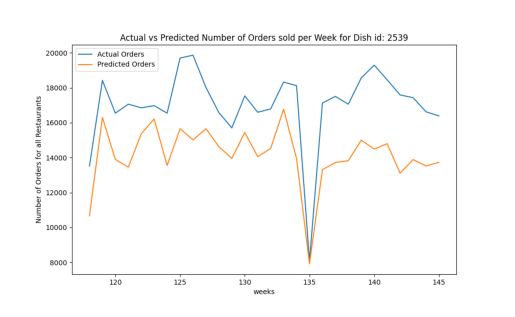

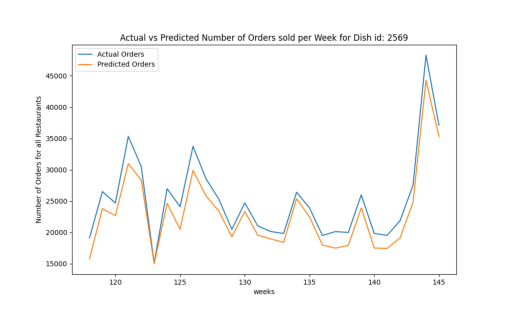

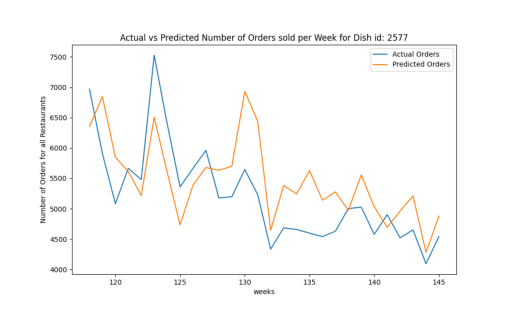

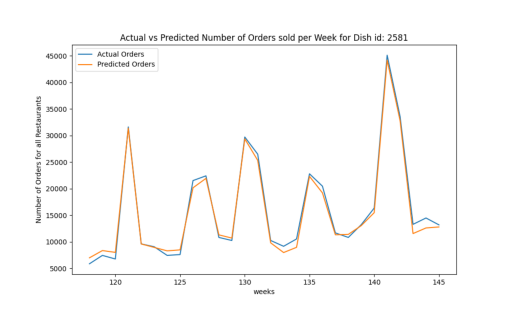

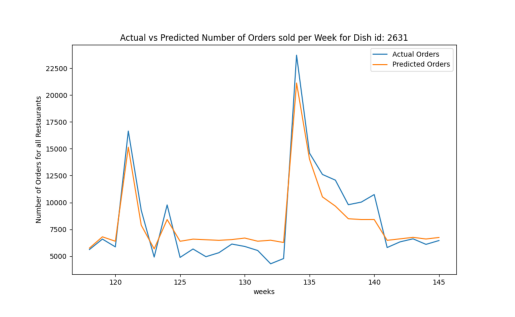

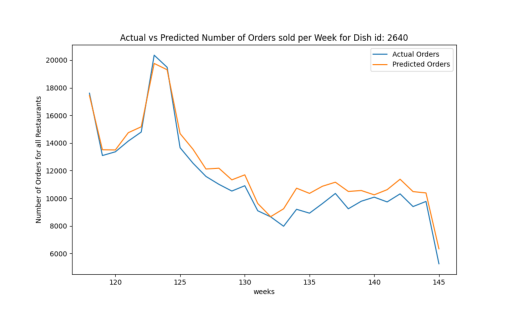

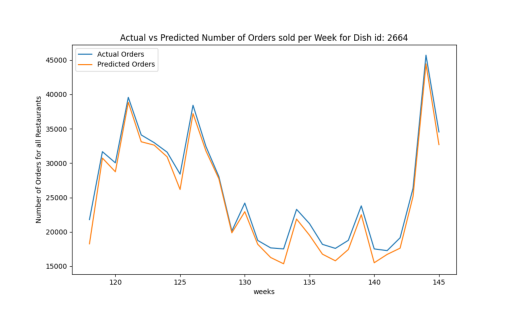

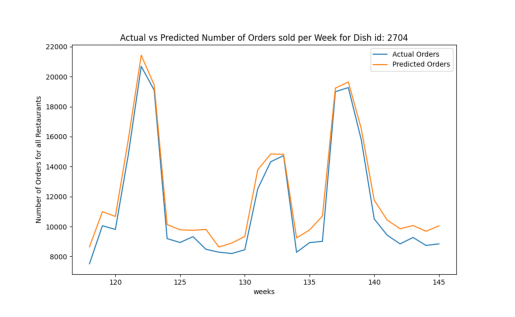

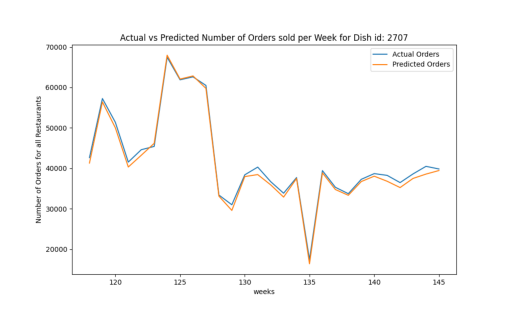

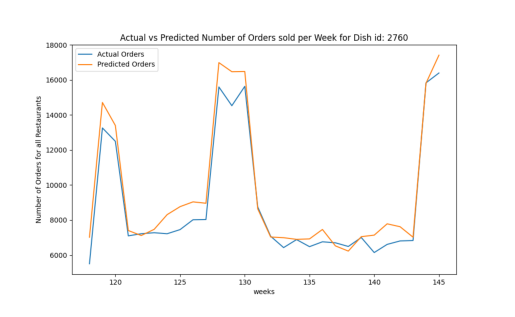

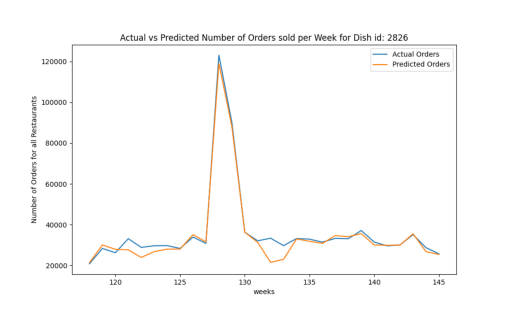

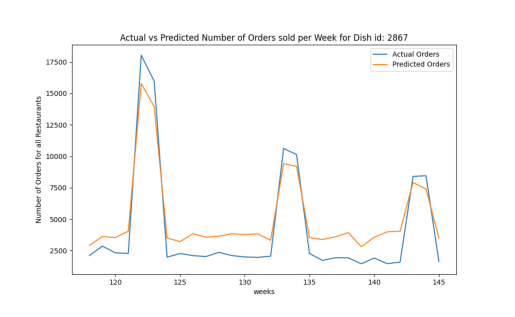

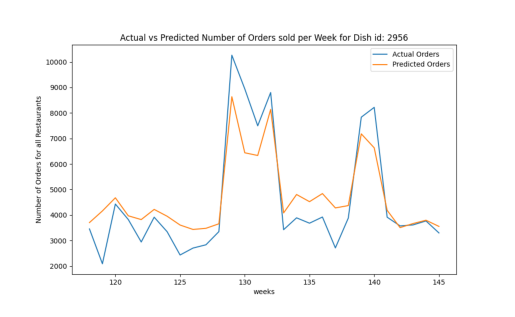


******************************************************



In [57]:
for folder, model in folderList:
    print("Graph generated using the ",model)
    generateAndSaveGraphs(folder, model, X_test=X_test,Y_test=Y_test, dish_id=dish_id)
    print("\n******************************************************\n")

In [58]:
def preprocessModule1(df):
    
    df['Week'] = df['Week'].astype('int64')
    df['Center Id'] = df['Center Id'].astype('int64')
    df['Dish Id'] = df['Dish Id'].astype('int64')
    df['Checkout Price'] = df['Checkout Price'].astype('float64')
    df['Base Price'] = df['Base Price'].astype('float64')
    df['Emailer For Promotion'] = df['Emailer For Promotion'].astype('int64')
    df['Homepage Featured'] = df['Homepage Featured'].astype('int64')

    #Remove unnecessary fields
    if "id" in list(df.columns):
        df = df.drop(['id'], axis=1) 
        
    if "Num Orders" in list(df.columns):
        df = df.drop(["Num Orders"], axis=1) 

    #Merging of dataframes
    df = df.merge(dishDf, left_on='Dish Id', right_on='Dish Id', how= "left")
    df = df.merge(centerDf, left_on='Center Id', right_on='Center Id', how= "left")

    #Encoding the record
    for name, data in encData.items():
        df = df.replace(name,data)

        
    return df

In [59]:
def numOrderPredictor(dat, model):
    numOrder = int(abs(model.predict(dat)))
    return numOrder

In [60]:
def quantityCalculator(dat, numOrder, inventory, ar):
    dId = list(dat["Dish Id"])[0]
    ing = ar[ar["Dish Id"] == dId]

    for i in ing.index:
        d = ar.iloc[ar.index == i]
        q = list(d["Quantity"])[0]
        n = list(d["Ingredient Name"])[0]
        u = list(d["Unit"])[0]
        nu = list(inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)]["Quantity"])[0]
        inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)] = inventory[(inventory["Ingredient Name"] ==  n) & (inventory["Unit"] ==  u)].replace(nu, nu + q*numOrder)

In [61]:
def quantityConverter(inventory,vm,rb):
    ind = 0
    for i in vm.index:
        dat = vm.iloc[rb.index == i]
        eq = list(dat["Equivalent Quantity"])[0]
        n = list(dat["Ingredient Name"])[0]
        u = list(dat["Unit"])[0]
        q = inventory._get_value(ind,'Quantity')
        ind += 1
        rb[(rb["Ingredient Name"] ==  n) & (rb["Unit"] ==  u)] = rb[(rb["Ingredient Name"] ==  n) & (rb["Unit"] ==  u)].replace(1, eq*q)
    rb = rb.drop(["Equivalent Quantity", "Unit"], axis = 1)
    rawMaterial = rb.groupby(['Ingredient Name', "C_unit"])['Quantity'].sum()
    rawMaterial = rawMaterial.to_frame()
    return rb

In [62]:
def rawMaterialQuantityIdentifier(dum, model):
    
    ar = pd.read_csv(r"..\Database\allRecipe.csv")
    ar = ar.sort_values(by = "Ingredient Name")
    vm = pd.read_csv(r"..\Database\vMeasurement.csv")
    inventory =  pd.read_csv(r"..\Database\inventory.csv")
    rb = vm
    
    dummy = dum
    dummy = preprocessModule1(dummy)
    dummy = preprocessSTL(dummy)
    
    order = []
    for i in dummy.index:
        d = {}
        numOrder = numOrderPredictor(dummy.iloc[dummy.index == i], model)
        quantityCalculator(dummy.iloc[dummy.index == i], numOrder, inventory, ar)
        d["Estimated Orders"] = numOrder
        order.append(d)
    rawMaterial = quantityConverter(inventory, vm, rb)
    
    order = pd.DataFrame(order)
    return order, rawMaterial[rawMaterial["Quantity"] != 0]

In [63]:
def inputData(df, model):
    
    orders, data = rawMaterialQuantityIdentifier(df, model) 
    return orders, data

In [64]:
saleDf = pd.read_csv(r"..\DataSet\Dish Sales dataset\sales_info.csv")
tempData = saleDf.sample()
tempData

id  Week  Center Id  Dish Id  Checkout Price  Base Price   
400202  1167827   128         80     1198          226.01      228.01  \

        Emailer For Promotion  Homepage Featured  Num Orders  
400202                      0                  0          81

In [65]:
O, M = inputData(tempData,getModel('hist_gradient_boosting'))

In [66]:
M

Ingredient Name   Quantity C_unit
61            flour  43.642500     Kg
97     onion powder   0.301125     Kg
118        sea salt   0.534600     Kg
119  semolina flour   5.524200     Kg
123       soy sauce   0.825000      L
146        zucchini   3.870900     Kg

# Simple Web Application

In [67]:
app = Flask(__name__)
app.config['SECRET_KEY'] = 'mysecretkey'

df_inputs = pd.DataFrame(columns=['Week',
                                  'Center Id',
                                  'Dish Name',
                                  'Checkout Price',
                                  'Base Price',
                                  'Emailer For Promotion',
                                  'Homepage Featured'])

df_output = pd.DataFrame(columns=['Ingredient Name', 'Quantity', 'C_unit'])


Ord = pd.DataFrame(columns=['Week',
                            'Center Id',
                            'Dish Name',
                            'Checkout Price',
                            'Base Price',
                            'Emailer For Promotion',
                            'Homepage Featured',
                             'Estimated Orders'])


@app.route('/', methods=['GET', 'POST'])
def index():
    global df_output
    global df_inputs
    global Ord 
    
    model_name = 'hist_gradient_boosting'
    empty_fields = {}
    
    if request.method == 'POST':
        if 'addItem' in request.form:
            week = request.form['week']
            centerId = request.form['center_id']
            dishName = request.form['dish_name']
            checkoutPrice = request.form['checkout_price']
            basePrice = request.form['base_price']
            emailerForPromotion = request.form['email_for_promotion']
            homepageFeatured = request.form['homepage_featured']
            
            empty_fields = {}
            mod = {}
            if not week:
                empty_fields['week'] = True
            if not centerId:
                empty_fields['center_id'] = True
            if not dishName:
                empty_fields['dish_name'] = True
            if not checkoutPrice:
                empty_fields['checkout_price'] = True
            if not basePrice:
                empty_fields['base_price'] = True
            if not emailerForPromotion:
                empty_fields['email_for_promotion'] = True
            if not homepageFeatured:
                empty_fields['homepage_featured'] = True
            
            if not empty_fields:
                df_inputs.loc[len(df_inputs)] = [week,
                                                 centerId,
                                                 dishName,
                                                 checkoutPrice,
                                                 basePrice,
                                                 emailerForPromotion,
                                                 homepageFeatured]
        
        elif 'deleteItem' in request.form:
            index = int(request.form['deleteItem'])
            if 0 <= index < len(df_inputs):
                df_inputs = df_inputs.drop(index)
                
        elif 'submit' in request.form:

            
            if len(df_inputs) != 0:
                
                inData = df_inputs.merge(recipeData, left_on='Dish Name', right_on='Dish Name', how= "left")
            
                inData = inData.drop(['Dish Name'], axis = 1) 
                
                model = getModel(model_name)
                
                if model is not None:
                    orders, df_output = inputData(inData, model)
                    
                    Ord = pd.concat([df_inputs, orders], axis = 1)
                
                else:
                    print("Model is none")
                
                
                
                
    else:
        
        empty_fields = {}
    
    dropdown_options_center_id = center_id 
    dropdown_options_dish_name = dish_name 
   
    return render_template('index.html',
                           empty_fields=empty_fields,
                           dropdown_options_center_id=dropdown_options_center_id,
                           dropdown_options_dish_name=dropdown_options_dish_name,
                           df_inputs=df_inputs.iterrows(),
                           df_output=df_output.to_dict('records'),
                            Ord = Ord.to_dict('records'))


if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [26/Sep/2023 17:49:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2023 17:49:34] "GET /static/main.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2023 17:49:46] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2023 17:49:46] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [26/Sep/2023 17:50:03] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2023 17:50:04] "GET /static/main.css HTTP/1.1" 304 -
127.0.0.1 - - [26/Sep/2023 17:51:47] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2023 17:51:47] "GET /static/main.css HTTP/1.1" 304 -
